In [1]:
!pip install -r requirements.txt

INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.2/33.2 MB 157.8 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.0/875.0 kB 120.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 127.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 232.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 254.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 237.6 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 216.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26/26 [lpips]m24/26 [spacy]hon]hon]


In [2]:
# ============================================
# CELL 2: Import All Packages
# ============================================
# Run this cell first in Jupyter notebook

import os
import sys
import json
import yaml
import random
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any
from collections import defaultdict
import logging

warnings.filterwarnings('ignore')

# Numerical Computing
import numpy as np
import pandas as pd
from scipy import stats

# Image Processing
import cv2
from PIL import Image
import imageio
from skimage.metrics import structural_similarity as ssim
from skimage import io as skio

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
import torchvision
from torchvision import transforms
from torchvision.models import resnet50, densenet121, vgg16

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

# NLP & Text Processing
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize
import spacy
from transformers import AutoTokenizer, AutoModel

# Metrics & Evaluation
import torchmetrics
from rouge_score import rouge_scorer
from sklearn.metrics import (
    precision_recall_fscore_support,
    hamming_loss,
    jaccard_score,
    average_precision_score
)

# Image Quality Metrics
try:
    from lpips import LPIPS
    LPIPS_AVAILABLE = True
except ImportError:
    LPIPS_AVAILABLE = False
    print("⚠️  LPIPS not available")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

# Logging
from torch.utils.tensorboard import SummaryWriter

# Try wandb
try:
    import wandb
    WANDB_AVAILABLE = True
except ImportError:
    WANDB_AVAILABLE = False

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

print("✅ All imports successful!")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
print(f"LPIPS Available: {LPIPS_AVAILABLE}")
print(f"Wandb Available: {WANDB_AVAILABLE}")

✅ All imports successful!
PyTorch Version: 2.8.0+cu128
CUDA Available: True
GPU: NVIDIA H200
CUDA Version: 12.8
LPIPS Available: True
Wandb Available: True


In [35]:
# ============================================
# CELL 3: Configuration & Setup
# ============================================

# -------------------
# 2. DATASET PATHS
# -------------------
# Update this path to your StoryReasoning dataset location
DATASET_BASE_PATH = "/teamspace/studios/this_studio/vist_kaggle"

# Dataset splits
TRAIN_JSON = f"{DATASET_BASE_PATH}/train.story-in-sequence.json"
VAL_JSON = f"{DATASET_BASE_PATH}/val.story-in-sequence.json"
TEST_JSON = f"{DATASET_BASE_PATH}/test.story-in-sequence.json"

# Images folder
IMAGES_PATH = f"{DATASET_BASE_PATH}/train_data"

# Output directories
OUTPUT_DIR = "/teamspace/studios/this_studio/vist_kaggle/srija_outputs"
CHECKPOINT_DIR = f"{OUTPUT_DIR}/checkpoints"
RESULTS_DIR = f"{OUTPUT_DIR}/results"
LOGS_DIR = f"{OUTPUT_DIR}/logs"

# Create output directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

print(f"📁 Dataset path: {DATASET_BASE_PATH}")
print(f"📁 Output directory: {OUTPUT_DIR}")

# -------------------
# 3. DEVICE CONFIGURATION
# -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"    GPU: {torch.cuda.get_device_name(0)}")
    print(f"    CUDA Version: {torch.version.cuda}")
    print(f"    Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# -------------------
# 4. RANDOM SEEDS (for reproducibility)
# -------------------
SEED = 42

def set_seed(seed=SEED):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)
print(f"\n🎲 Random seed set to: {SEED}")

# -------------------
# 5. HYPERPARAMETERS CONFIGURATION
# -------------------

config = {
    # ============ DATA PARAMETERS ============
    "data": {
        "num_frames": 5,  # K frames as input (predict K+1)
        "image_size": 224,  # ResNet input size
        "max_text_length": 30,  # Max words per caption
        "vocab_size": 10000,  # Vocabulary size
        "train_split": 0.8,
        "val_split": 0.1,
        "test_split": 0.1,
    },

    # ============ MODEL ARCHITECTURE ============
    "model": {
        # Visual Encoder
        "visual_encoder": "resnet50",  # Options: resnet50, densenet121, vgg16
        "visual_feature_dim": 2048,  # ResNet50 output
        "freeze_visual_encoder": False,  # Fine-tune last layers

        # Text Encoder
        "text_embedding_dim": 300,  # Word embedding size
        "text_hidden_dim": 512,  # LSTM hidden size
        "text_num_layers": 2,  # LSTM layers
        "text_bidirectional": True,
        "text_encoder_output_dim": 1024,  # 512*2 for bidirectional

        # Fusion Layer
        "fusion_dim": 1024,  # After concatenation projection
        "fusion_dropout": 0.3,

        # Tag Prediction Head (INNOVATION)
        "tag_vocab_size": 100,  # Number of possible tags
        "tag_embedding_dim": 128,  # Tag embedding size
        "tag_hidden_dim": 512,  # Tag prediction hidden layer
        "tag_dropout": 0.4,

        # Sequence Model
        "sequence_hidden_dim": 1024,
        "sequence_num_layers": 2,
        "sequence_dropout": 0.3,

        # Attention Mechanism
        "attention_dim": 1024,
        "attention_heads": 8,  # Multi-head attention

        # Image Decoder
        "image_decoder_hidden_dims": [1024, 2048, 2048],
        "image_decoder_dropout": 0.3,

        # Text Decoder
        "text_decoder_hidden_dim": 1024,
        "text_decoder_num_layers": 2,
        "text_decoder_dropout": 0.3,
    },

    # ============ TRAINING PARAMETERS ============
    "training": {
        "batch_size": 16,  # Adjust based on GPU memory
        "num_epochs": 10,
        "learning_rate": 1e-4,
        "weight_decay": 1e-5,  # L2 regularization
        "grad_clip_norm": 1.0,  # Gradient clipping

        # Loss weights (MULTI-TASK LEARNING)
        "lambda_image": 1.0,  # Image prediction loss weight
        "lambda_text": 1.0,   # Text prediction loss weight
        "lambda_tag": 0.3,    # Tag prediction loss weight (AUXILIARY TASK)

        # Optimizer
        "optimizer": "adam",  # Options: adam, adamw, sgd
        "betas": (0.9, 0.999),
        "eps": 1e-8,

        # Learning Rate Scheduler
        "scheduler": "reduce_on_plateau",  # Options: reduce_on_plateau, cosine, step
        "scheduler_patience": 5,
        "scheduler_factor": 0.5,
        "scheduler_min_lr": 1e-7,

        # Early Stopping
        "early_stopping": True,
        "early_stopping_patience": 10,

        # Checkpointing
        "save_every_n_epochs": 5,
        "save_best_only": True,
    },

    # ============ DATA AUGMENTATION ============
    "augmentation": {
        "horizontal_flip": True,
        "random_crop": True,
        "color_jitter": True,
        "rotation": 5,  # degrees
    },

    # ============ EVALUATION PARAMETERS ============
    "evaluation": {
        # Image metrics
        "use_ssim": True,
        "use_lpips": LPIPS_AVAILABLE,
        "use_psnr": True,

        # Text metrics
        "use_bleu": True,
        "use_rouge": True,
        "use_perplexity": True,

        # Tag metrics
        "tag_threshold": 0.5,  # Probability threshold for tag prediction
    },

    # ============ LOGGING & VISUALIZATION ============
    "logging": {
        "log_every_n_steps": 50,
        "visualize_every_n_epochs": 5,
        "num_samples_to_visualize": 4,
        "use_tensorboard": True,
        "use_wandb": WANDB_AVAILABLE,
        "wandb_project": "srija-visual-storytelling",
        "wandb_entity": None,  # Your wandb username (optional)
    },

    # ============ TAG CATEGORIES ============
    "tags": {
        "objects": [
            "person", "dog", "cat", "car", "table", "chair", "cup",
            "bottle", "tree", "building", "phone", "laptop", "book",
            "bed", "window", "door", "plant", "bicycle", "motorcycle"
        ],
        "actions": [
            "walking", "running", "sitting", "standing", "eating",
            "drinking", "reading", "writing", "talking", "smiling",
            "jumping", "sleeping", "cooking", "driving", "dancing"
        ],
        "locations": [
            "kitchen", "bedroom", "living_room", "office", "street",
            "park", "restaurant", "beach", "forest", "city", "home",
            "school", "hospital", "store", "garden"
        ]
    },

    # ============ EXPERIMENT TRACKING ============
    "experiment": {
        "name": "srija_multitask_baseline",
        "description": "Multi-task learning with tag prediction for visual storytelling",
        "tags": ["multi-task", "visual-storytelling", "tag-prediction"],
        "notes": "Baseline experiment with lambda_tag=0.3",
    }
}

# -------------------
# 6. TAG VOCABULARY SETUP
# -------------------
# Flatten all tag categories into single vocabulary
all_tags = (
    config["tags"]["objects"] +
    config["tags"]["actions"] +
    config["tags"]["locations"]
)

# Add special tokens
TAG_VOCAB = ["<PAD>", "<UNK>"] + all_tags
config["model"]["tag_vocab_size"] = len(TAG_VOCAB)

# Create tag to index mapping
tag2idx = {tag: idx for idx, tag in enumerate(TAG_VOCAB)}
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

print(f"\n🏷️  Tag Vocabulary Size: {len(TAG_VOCAB)}")
print(f"    Objects: {len(config['tags']['objects'])}")
print(f"    Actions: {len(config['tags']['actions'])}")
print(f"    Locations: {len(config['tags']['locations'])}")

# -------------------
# 7. PRINT CONFIGURATION SUMMARY
# -------------------
print("\n" + "="*60)
print("📋 CONFIGURATION SUMMARY")
print("="*60)

print(f"\n📊 Data:")
print(f"  • Sequence length (K): {config['data']['num_frames']}")
print(f"  • Image size: {config['data']['image_size']}x{config['data']['image_size']}")
print(f"  • Max text length: {config['data']['max_text_length']} words")
print(f"  • Vocabulary size: {config['data']['vocab_size']}")

print(f"\n🏗️  Model Architecture:")
print(f"  • Visual encoder: {config['model']['visual_encoder']}")
print(f"  • Visual features: {config['model']['visual_feature_dim']}-dim")
print(f"  • Text encoder: {config['model']['text_num_layers']}-layer {'Bi' if config['model']['text_bidirectional'] else ''}LSTM")
print(f"  • Text hidden: {config['model']['text_hidden_dim']}-dim")
print(f"  • Tag prediction: {config['model']['tag_vocab_size']} tags")
print(f"  • Tag embedding: {config['model']['tag_embedding_dim']}-dim")

print(f"\n🎯 Training:")
print(f"  • Batch size: {config['training']['batch_size']}")
print(f"  • Epochs: {config['training']['num_epochs']}")
print(f"  • Learning rate: {config['training']['learning_rate']}")
print(f"  • Optimizer: {config['training']['optimizer']}")

print(f"\n⚖️  Multi-Task Loss Weights:")
print(f"  • λ_image: {config['training']['lambda_image']}")
print(f"  • λ_text: {config['training']['lambda_text']}")
print(f"  • λ_tag: {config['training']['lambda_tag']} (AUXILIARY)")

print(f"\n📈 Evaluation Metrics:")
print(f"  • SSIM: {config['evaluation']['use_ssim']}")
print(f"  • LPIPS: {config['evaluation']['use_lpips']}")
print(f"  • BLEU: {config['evaluation']['use_bleu']}")
print(f"  • ROUGE: {config['evaluation']['use_rouge']}")
print(f"  • Perplexity: {config['evaluation']['use_perplexity']}")

print(f"\n📁 Paths:")
print(f"  • Dataset: {DATASET_BASE_PATH}")
print(f"  • Checkpoints: {CHECKPOINT_DIR}")
print(f"  • Results: {RESULTS_DIR}")
print(f"  • Logs: {LOGS_DIR}")

print("\n" + "="*60)
print("✅ Configuration complete! Ready for next cell.")
print("="*60)

# -------------------
# 8. SAVE CONFIGURATION
# -------------------
config_save_path = f"{OUTPUT_DIR}/config.yaml"
with open(config_save_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False, sort_keys=False)

print(f"\n💾 Configuration saved to: {config_save_path}")


📁 Dataset path: /teamspace/studios/this_studio/vist_kaggle
📁 Output directory: /teamspace/studios/this_studio/vist_kaggle/srija_outputs

🖥️  Device: cuda
    GPU: NVIDIA H200
    CUDA Version: 12.8
    Memory: 150.12 GB

🎲 Random seed set to: 42

🏷️  Tag Vocabulary Size: 51
    Objects: 19
    Actions: 15
    Locations: 15

📋 CONFIGURATION SUMMARY

📊 Data:
  • Sequence length (K): 5
  • Image size: 224x224
  • Max text length: 30 words
  • Vocabulary size: 10000

🏗️  Model Architecture:
  • Visual encoder: resnet50
  • Visual features: 2048-dim
  • Text encoder: 2-layer BiLSTM
  • Text hidden: 512-dim
  • Tag prediction: 51 tags
  • Tag embedding: 128-dim

🎯 Training:
  • Batch size: 16
  • Epochs: 10
  • Learning rate: 0.0001
  • Optimizer: adam

⚖️  Multi-Task Loss Weights:
  • λ_image: 1.0
  • λ_text: 1.0
  • λ_tag: 0.3 (AUXILIARY)

📈 Evaluation Metrics:
  • SSIM: True
  • LPIPS: True
  • BLEU: True
  • ROUGE: True
  • Perplexity: True

📁 Paths:
  • Dataset: /teamspace/studios/this_

In [36]:
# ============================================
# CELL 4 (CORRECTED): Load & Order Stories
# ============================================

import json
from pprint import pprint
from collections import defaultdict

# ---- Load train.json ----
with open(TRAIN_JSON, "r", encoding="utf-8") as f:
    train_data = json.load(f)

print("✅ Loaded TRAIN JSON")
print("Top-level keys:", list(train_data.keys()))

# =========================================================
# PART A: Build lookup tables with ORDERING INFO
# =========================================================

# annotations[i][0] has: story_id, photo_flickr_id, worker_arranged_photo_order, text
# We need to keep worker_arranged_photo_order to order frames correctly

photo_to_caption = {}
for ann_list in train_data["annotations"]:
    if not ann_list:
        continue
    ann = ann_list[0]
    pid = str(ann.get("photo_flickr_id", ""))
    if pid:
        photo_to_caption[pid] = {
            "story_id": str(ann.get("story_id", "")),
            "text": ann.get("text", ""),
            "photo_order": int(ann.get("worker_arranged_photo_order", -1))  # FRAME ORDER
        }

print("✅ Built photo_to_caption with ordering")
print(f"   Total photo captions: {len(photo_to_caption)}")

# image id -> url_o
imageid_to_url = {}
for im in train_data["images"]:
    iid = str(im.get("id", ""))
    if iid:
        imageid_to_url[iid] = im.get("url_o", "")

print("✅ Built imageid_to_url")
print(f"   Total images: {len(imageid_to_url)}")

# =========================================================
# PART B: Group frames by story_id AND SORT BY ORDER
# =========================================================

stories_dict = defaultdict(list)

for im in train_data["images"]:
    iid = str(im.get("id", ""))
    if not iid:
        continue

    cap = photo_to_caption.get(iid)
    if cap is None:
        continue

    url = im.get("url_o", "")

    # Add frame to story with ALL info
    stories_dict[cap["story_id"]].append({
        "frame_order": cap["photo_order"],  # Position in story sequence
        "id": iid,
        "url_o": url,
        "text": cap["text"]
    })

# SORT EACH STORY BY frame_order
for story_id in stories_dict:
    stories_dict[story_id].sort(key=lambda x: x["frame_order"])

print("\n✅ Grouped & sorted stories by frame_order")
print(f"   Total unique story_id: {len(stories_dict)}")

# Filter stories: keep only those with ≥ 5 frames (for K=5 input)
min_frames = 5
filtered_stories = {
    sid: frames for sid, frames in stories_dict.items()
    if len(frames) >= min_frames
}

print(f"   Stories with ≥ {min_frames} frames: {len(filtered_stories)}")

# =========================================================
# PART C: Display TOP 5 COMPLETE STORIES
# =========================================================

print("\n" + "="*100)
print("📚 TOP 5 COMPLETE STORIES (WITH PROPER FRAME ORDERING)")
print("="*100)

story_ids_sorted = sorted(filtered_stories.keys())[:5]

for idx, story_id in enumerate(story_ids_sorted, 1):
    frames = filtered_stories[story_id]
    print(f"\n{'─'*100}")
    print(f"STORY #{idx}: story_id = {story_id}")
    print(f"Total frames: {len(frames)}")
    print(f"{'─'*100}")

    for frame_idx, frame in enumerate(frames, 1):
        print(f"\n  Frame {frame_idx} (order={frame['frame_order']}):")
        print(f"    ID:   {frame['id']}")
        print(f"    Text: {frame['text'][:80]}...")
        print(f"    URL:  {frame['url_o'][:70]}...")

# =========================================================
# PART D: Statistics
# =========================================================

print("\n" + "="*100)
print("📊 DATASET STATISTICS")
print("="*100)

frame_counts = [len(f) for f in filtered_stories.values()]
print(f"\n✅ Stories with ≥{min_frames} frames: {len(filtered_stories)}")
print(f"   Min frames per story: {min(frame_counts)}")
print(f"   Max frames per story: {max(frame_counts)}")
print(f"   Avg frames per story: {sum(frame_counts)/len(frame_counts):.2f}")

# =========================================================
# PART E: Save for next cells
# =========================================================

# Store in global variables for use in next cells
STORIES = filtered_stories  # dict[story_id] -> list of ordered frames
ALL_STORY_IDS = list(filtered_stories.keys())

print(f"\n✅ Saved STORIES dict to memory")
print(f"   Variable name: STORIES")
print(f"   Access: STORIES[story_id] -> list of frames with frame_order, id, url_o, text")

✅ Loaded TRAIN JSON
Top-level keys: ['images', 'info', 'albums', 'type', 'annotations']
✅ Built photo_to_caption with ordering
   Total photo captions: 64934
✅ Built imageid_to_url
   Total images: 167528

✅ Grouped & sorted stories by frame_order
   Total unique story_id: 16021
   Stories with ≥ 5 frames: 8831

📚 TOP 5 COMPLETE STORIES (WITH PROPER FRAME ORDERING)

────────────────────────────────────────────────────────────────────────────────────────────────────
STORY #1: story_id = 10004
Total frames: 5
────────────────────────────────────────────────────────────────────────────────────────────────────

  Frame 1 (order=0):
    ID:   5574199804
    Text: we got stuck in traffic for a long time ....
    URL:  https://farm6.staticflickr.com/5150/5574199804_c5cf7712d6_o.jpg...

  Frame 2 (order=1):
    ID:   5573613249
    Text: the cars were stopped for as far as i could see ....
    URL:  https://farm6.staticflickr.com/5221/5573613249_19460c3b9e_o.jpg...

  Frame 3 (order=2):
    ID

In [37]:
# ============================================
# CELL 5 (COMPLETE): Custom Dataset Class + Subset
# ============================================

from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
from io import BytesIO
import requests


# =========================================================
# PART A: SIMPLE TOKENIZER
# =========================================================

class SimpleTokenizer:
    """Basic word-level tokenizer with vocabulary"""

    def __init__(self, vocab_size=10000):
        self.vocab_size = vocab_size
        self.word2idx = {"<PAD>": 0, "<UNK>": 1, "<SOS>": 2, "<EOS>": 3}
        self.idx2word = {v: k for k, v in self.word2idx.items()}
        self.word_freq = {}

    def build_vocab(self, texts):
        """Build vocabulary from list of texts"""
        print("🔨 Building vocabulary...")

        for text in texts:
            words = text.lower().split()
            for word in words:
                self.word_freq[word] = self.word_freq.get(word, 0) + 1

        sorted_words = sorted(self.word_freq.items(), key=lambda x: x[1], reverse=True)

        for idx, (word, freq) in enumerate(sorted_words[:self.vocab_size-4], 4):
            self.word2idx[word] = idx
            self.idx2word[idx] = word

        print(f"✅ Vocabulary built: {len(self.word2idx)} tokens")
        return self

    def encode(self, text, max_length=30, pad=True):
        """Convert text to token indices"""
        words = text.lower().split()[:max_length]
        tokens = [self.word2idx.get(w, 1) for w in words]

        if pad:
            if len(tokens) < max_length:
                tokens = tokens + [0] * (max_length - len(tokens))
            else:
                tokens = tokens[:max_length]

        return tokens

    def decode(self, tokens):
        """Convert token indices back to text"""
        words = [self.idx2word.get(int(t), "<UNK>") for t in tokens if t > 0]
        return " ".join(words)


# =========================================================
# PART B: IMAGE LOADING UTILITIES
# =========================================================

def load_image_from_url(url, image_size=224, timeout=5):
    """Load image from URL"""
    try:
        response = requests.get(url, timeout=timeout)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        return img
    except Exception as e:
        return None


def create_dummy_image(image_size=224):
    """Create dummy image if loading fails"""
    return Image.new("RGB", (image_size, image_size), color=(128, 128, 128))


# =========================================================
# PART C: CUSTOM DATASET CLASS
# =========================================================

class StorySequenceDataset(Dataset):
    """
    Dataset for visual storytelling.

    Strategy: For each story with K frames,
    - Input: frames[0:K] (all K frames)
    - Target: frames[K-1] (last frame as target, which is frame K)

    This works because VIST stories have exactly K=5 frames each.
    """

    def __init__(
        self,
        stories_dict,
        tokenizer,
        image_size=224,
        max_text_length=30,
        num_frames=5,
        augment=True
    ):
        self.stories = stories_dict
        self.tokenizer = tokenizer
        self.image_size = image_size
        self.max_text_length = max_text_length
        self.num_frames = num_frames

        # Build list of story_ids with correct number of frames
        self.story_ids = [
            sid for sid, frames in stories_dict.items()
            if len(frames) >= num_frames
        ]

        print(f"   Found {len(self.story_ids)} stories with ≥{num_frames} frames")

        # Image preprocessing
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        # Data augmentation (optional)
        self.augment = augment
        if augment:
            self.augment_transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.RandomRotation(5),
            ])

    def __len__(self):
        return len(self.story_ids)

    def __getitem__(self, idx):
        """Get one training sample"""
        story_id = self.story_ids[idx]
        frames = self.stories[story_id]

        # Use first K frames as input
        input_frames = frames[:self.num_frames]
        # Use the LAST of the K frames as target
        target_frame = frames[self.num_frames - 1]

        # Load and process images
        input_images = []
        for frame in input_frames:
            img = load_image_from_url(frame["url_o"], self.image_size)
            if img is None:
                img = create_dummy_image(self.image_size)

            # Apply augmentation to input images
            if self.augment:
                img = self.augment_transform(img)

            img = self.transform(img)
            input_images.append(img)

        # Load target image
        target_img = load_image_from_url(target_frame["url_o"], self.image_size)
        if target_img is None:
            target_img = create_dummy_image(self.image_size)

        target_img = self.transform(target_img)

        # Stack images: shape (K, 3, H, W)
        input_images = torch.stack(input_images, dim=0)

        # Tokenize texts
        input_texts = [frame["text"] for frame in input_frames]
        target_text = target_frame["text"]

        input_tokens = [self.tokenizer.encode(text, self.max_text_length) for text in input_texts]
        input_tokens = torch.tensor(input_tokens, dtype=torch.long)

        target_tokens = torch.tensor(
            self.tokenizer.encode(target_text, self.max_text_length),
            dtype=torch.long
        )

        return {
            "story_id": story_id,
            "input_images": input_images,
            "input_texts": input_texts,
            "input_tokens": input_tokens,
            "target_image": target_img,
            "target_text": target_text,
            "target_tokens": target_tokens
        }


# =========================================================
# PART D: BUILD VOCABULARY & TOKENIZER
# =========================================================

all_texts = []
for story_id, frames in STORIES.items():
    for frame in frames:
        all_texts.append(frame["text"])

print(f"\n📝 Building tokenizer from {len(all_texts)} texts...")
tokenizer = SimpleTokenizer(vocab_size=config["data"]["vocab_size"])
tokenizer.build_vocab(all_texts)

import pickle
tokenizer_path = f"{OUTPUT_DIR}/tokenizer.pkl"
with open(tokenizer_path, "wb") as f:
    pickle.dump(tokenizer, f)
print(f"💾 Tokenizer saved to: {tokenizer_path}")


# =========================================================
# PART E: CREATE DATASETS & DATALOADERS
# =========================================================

# Split stories into train/val/test
story_ids = list(STORIES.keys())
n_stories = len(story_ids)
n_train = int(n_stories * config["data"]["train_split"])
n_val = int(n_stories * config["data"]["val_split"])

set_seed(SEED)
random.shuffle(story_ids)

train_story_ids = story_ids[:n_train]
val_story_ids = story_ids[n_train:n_train + n_val]
test_story_ids = story_ids[n_train + n_val:]

train_stories = {sid: STORIES[sid] for sid in train_story_ids}
val_stories = {sid: STORIES[sid] for sid in val_story_ids}
test_stories = {sid: STORIES[sid] for sid in test_story_ids}

print(f"\n📊 Data split (BEFORE subset):")
print(f"   Train stories: {len(train_stories)}")
print(f"   Val stories: {len(val_stories)}")
print(f"   Test stories: {len(test_stories)}")

# Create full datasets
print(f"\n🔧 Creating full datasets...")
train_dataset_full = StorySequenceDataset(
    train_stories,
    tokenizer,
    image_size=config["data"]["image_size"],
    max_text_length=config["data"]["max_text_length"],
    num_frames=config["data"]["num_frames"],
    augment=True
)

val_dataset_full = StorySequenceDataset(
    val_stories,
    tokenizer,
    image_size=config["data"]["image_size"],
    max_text_length=config["data"]["max_text_length"],
    num_frames=config["data"]["num_frames"],
    augment=False
)

test_dataset_full = StorySequenceDataset(
    test_stories,
    tokenizer,
    image_size=config["data"]["image_size"],
    max_text_length=config["data"]["max_text_length"],
    num_frames=config["data"]["num_frames"],
    augment=False
)

# ========================================
# ⚠️  SUBSET FOR TESTING (MODIFY HERE)
# ========================================

SUBSET_SIZE = 200  # ← CHANGE THIS VALUE
USE_SUBSET = True  # Set to False to use full dataset

if USE_SUBSET:
    print(f"\n⚠️  USING SUBSET FOR TESTING")
    print(f"   Original train: {len(train_dataset_full)}")
    print(f"   Subset size: {SUBSET_SIZE}")

    # Create subsets
    train_indices = list(range(min(SUBSET_SIZE, len(train_dataset_full))))
    val_indices = list(range(min(SUBSET_SIZE // 5, len(val_dataset_full))))
    test_indices = list(range(min(SUBSET_SIZE // 5, len(test_dataset_full))))

    train_dataset = Subset(train_dataset_full, train_indices)
    val_dataset = Subset(val_dataset_full, val_indices)
    test_dataset = Subset(test_dataset_full, test_indices)

    print(f"   New train: {len(train_dataset)}")
    print(f"   New val: {len(val_dataset)}")
    print(f"   New test: {len(test_dataset)}")
else:
    print(f"\n✅ USING FULL DATASET")
    train_dataset = train_dataset_full
    val_dataset = val_dataset_full
    test_dataset = test_dataset_full

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config["training"]["batch_size"],
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config["training"]["batch_size"],
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config["training"]["batch_size"],
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"\n✅ DataLoaders created:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")
print(f"   Batch size: {config['training']['batch_size']}")

# Estimate training time
est_time_per_epoch = len(train_loader) * 5 / 60
est_total_time = est_time_per_epoch * config['training']['num_epochs']
print(f"\n⏱️  Estimated training time:")
print(f"   Per epoch: ~{est_time_per_epoch:.1f} minutes")
print(f"   Total ({config['training']['num_epochs']} epochs): ~{est_total_time:.1f} minutes")

# =========================================================
# PART F: TEST ONE BATCH
# =========================================================

print("\n" + "="*80)
print("🧪 Testing one batch from train_loader")
print("="*80)

try:
    sample_batch = next(iter(train_loader))
    print(f"\n✅ Successfully loaded batch!")
    print(f"📦 Batch keys: {list(sample_batch.keys())}")
    print(f"   input_images shape: {sample_batch['input_images'].shape}")
    print(f"   input_tokens shape: {sample_batch['input_tokens'].shape}")
    print(f"   target_image shape: {sample_batch['target_image'].shape}")
    print(f"   target_tokens shape: {sample_batch['target_tokens'].shape}")

    print(f"\n📝 Sample input texts (first sequence):")
    for i in range(config["data"]["num_frames"]):
        text = sample_batch['input_texts'][i]
        print(f"   Frame {i+1}: {text[:70]}...")

    print(f"\n🎯 Sample target text:")
    print(f"   {sample_batch['target_text'][0][:70]}...")

except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

print("\n✅ Dataset loading successful!")
print("="*80)


📝 Building tokenizer from 44155 texts...
🔨 Building vocabulary...
✅ Vocabulary built: 10000 tokens
💾 Tokenizer saved to: /teamspace/studios/this_studio/vist_kaggle/srija_outputs/tokenizer.pkl

📊 Data split (BEFORE subset):
   Train stories: 7064
   Val stories: 883
   Test stories: 884

🔧 Creating full datasets...
   Found 7064 stories with ≥5 frames
   Found 883 stories with ≥5 frames
   Found 884 stories with ≥5 frames

⚠️  USING SUBSET FOR TESTING
   Original train: 7064
   Subset size: 200
   New train: 200
   New val: 40
   New test: 40

✅ DataLoaders created:
   Train batches: 13
   Val batches: 3
   Test batches: 3
   Batch size: 16

⏱️  Estimated training time:
   Per epoch: ~1.1 minutes
   Total (10 epochs): ~10.8 minutes

🧪 Testing one batch from train_loader



✅ Successfully loaded batch!
📦 Batch keys: ['story_id', 'input_images', 'input_texts', 'input_tokens', 'target_image', 'target_text', 'target_tokens']
   input_images shape: torch.Size([16, 5, 3, 224, 224])
   input_tokens shape: torch.Size([16, 5, 30])
   target_image shape: torch.Size([16, 3, 224, 224])
   target_tokens shape: torch.Size([16, 30])

📝 Sample input texts (first sequence):
   Frame 1: ['my family decided that we should go check out medieval times while we were in the city . they gave us each a crown to wear during the show .', 'it was my first night out in awhile and i was excited .', 'waiting at the top for a pleasure boat ride .', 'we hung out to show off new tricks that we learned on our bikes .', 'today was the first day of our trip to location .', 'fran was not very enthused about marrying [male] .', 'there was lots of food in the kitchen', 'the dancers really put on a great performance for the event .', '[female] dressed up in costume for the casino . she was rea

In [38]:
# ============================================
# CELL 6: Visual Encoder (CNN)
# ============================================

import torchvision.models as models

class VisualEncoder(nn.Module):
    """
    CNN-based visual encoder using ResNet50.
    Extracts 2048-dimensional feature vectors from images.
    """

    def __init__(self, config):
        super(VisualEncoder, self).__init__()

        self.feature_dim = config["model"]["visual_feature_dim"]

        # Load pre-trained ResNet50
        resnet50 = models.resnet50(pretrained=True)

        # Remove the final classification layer
        self.backbone = nn.Sequential(*list(resnet50.children())[:-1])

        # Freeze early layers if specified
        if config["model"]["freeze_visual_encoder"]:
            for param in self.backbone[:-1].parameters():
                param.requires_grad = False
            print("🔒 Early layers of ResNet50 frozen")
        else:
            print("🔓 All ResNet50 layers trainable")

        print(f"✅ Visual Encoder initialized")
        print(f"   Output dim: {self.feature_dim}")

    def forward(self, images):
        """
        Args:
            images: (batch_size, K, 3, H, W) - K frames per story

        Returns:
            features: (batch_size, K, feature_dim)
        """
        batch_size, K, C, H, W = images.shape

        # Reshape to process all frames at once
        images = images.view(batch_size * K, C, H, W)

        # Extract features
        features = self.backbone(images)  # (batch_size*K, feature_dim, 1, 1)
        features = features.squeeze(-1).squeeze(-1)  # (batch_size*K, feature_dim)

        # Reshape back
        features = features.view(batch_size, K, self.feature_dim)

        return features


# =========================================================
# TEST THE VISUAL ENCODER
# =========================================================

print("\n" + "="*80)
print("🧪 Testing Visual Encoder")
print("="*80)

visual_encoder = VisualEncoder(config).to(device)

# Create dummy input: (batch_size=2, K=5, 3, 224, 224)
dummy_images = torch.randn(2, config["data"]["num_frames"], 3, 224, 224).to(device)

with torch.no_grad():
    visual_features = visual_encoder(dummy_images)

print(f"\n✅ Visual Encoder Test Passed!")
print(f"   Input shape: {dummy_images.shape}")
print(f"   Output shape: {visual_features.shape}")
print(f"   Expected: (batch_size=2, K=5, feature_dim=2048)")

# Count parameters
total_params = sum(p.numel() for p in visual_encoder.parameters())
trainable_params = sum(p.numel() for p in visual_encoder.parameters() if p.requires_grad)
print(f"\n📊 Parameters:")
print(f"   Total: {total_params:,}")
print(f"   Trainable: {trainable_params:,}")


🧪 Testing Visual Encoder
🔓 All ResNet50 layers trainable
✅ Visual Encoder initialized
   Output dim: 2048

✅ Visual Encoder Test Passed!
   Input shape: torch.Size([2, 5, 3, 224, 224])
   Output shape: torch.Size([2, 5, 2048])
   Expected: (batch_size=2, K=5, feature_dim=2048)

📊 Parameters:
   Total: 23,508,032
   Trainable: 23,508,032


In [39]:
# ============================================
# TEST VISUAL ENCODER WITH REAL DATA
# ============================================

print("\n" + "="*80)
print("🧪 Testing Visual Encoder with REAL BATCH from train_loader")
print("="*80)

# Get one real batch
real_batch = next(iter(train_loader))
real_images = real_batch['input_images'].to(device)  # (batch_size, K, 3, 224, 224)

print(f"\n📦 Real batch info:")
print(f"   Batch size: {real_images.shape[0]}")
print(f"   Num frames (K): {real_images.shape[1]}")
print(f"   Image shape: {real_images.shape[2:]}")
print(f"   Story IDs: {real_batch['story_id'][:3]}...")

# Forward pass
print(f"\n🔄 Running forward pass...")
with torch.no_grad():
    visual_features = visual_encoder(real_images)

print(f"\n✅ Forward pass successful!")
print(f"   Input shape: {real_images.shape}")
print(f"   Output shape: {visual_features.shape}")

# Check feature statistics
print(f"\n📊 Feature statistics:")
print(f"   Mean: {visual_features.mean().item():.4f}")
print(f"   Std: {visual_features.std().item():.4f}")
print(f"   Min: {visual_features.min().item():.4f}")
print(f"   Max: {visual_features.max().item():.4f}")

# Check for NaN or Inf
has_nan = torch.isnan(visual_features).any()
has_inf = torch.isinf(visual_features).any()
print(f"   Contains NaN: {has_nan}")
print(f"   Contains Inf: {has_inf}")

# Visualize feature for first image in batch
print(f"\n🔍 First frame features (first 10 dimensions):")
print(f"   {visual_features[0, 0, :10]}")

# Check feature diversity across frames
print(f"\n📈 Feature diversity (L2 distance between consecutive frames):")
for i in range(config["data"]["num_frames"] - 1):
    dist = torch.norm(visual_features[0, i] - visual_features[0, i+1]).item()
    print(f"   Frame {i} → Frame {i+1}: {dist:.4f}")

print("\n✅ Visual Encoder validation complete!")
print("   All checks passed!" if not (has_nan or has_inf) else "   ⚠️ Warning: NaN/Inf detected!")


🧪 Testing Visual Encoder with REAL BATCH from train_loader



📦 Real batch info:
   Batch size: 16
   Num frames (K): 5
   Image shape: torch.Size([3, 224, 224])
   Story IDs: ['11229', '17719', '15014']...

🔄 Running forward pass...

✅ Forward pass successful!
   Input shape: torch.Size([16, 5, 3, 224, 224])
   Output shape: torch.Size([16, 5, 2048])

📊 Feature statistics:
   Mean: 0.4486
   Std: 0.3798
   Min: 0.0000
   Max: 4.5865
   Contains NaN: False
   Contains Inf: False

🔍 First frame features (first 10 dimensions):
   tensor([0.7832, 1.7900, 1.0718, 0.0943, 0.7175, 1.1377, 0.5882, 0.7906, 0.3718,
        0.3748], device='cuda:0')

📈 Feature diversity (L2 distance between consecutive frames):
   Frame 0 → Frame 1: 20.7952
   Frame 1 → Frame 2: 20.0023
   Frame 2 → Frame 3: 17.0882
   Frame 3 → Frame 4: 22.3293

✅ Visual Encoder validation complete!
   All checks passed!


In [40]:
# ============================================
# CELL 7: Text Encoder (BiLSTM)
# ============================================

class TextEncoder(nn.Module):
    """
    Bidirectional LSTM-based text encoder.
    Encodes text captions into fixed-size feature vectors.
    """

    def __init__(self, config, vocab_size):
        super(TextEncoder, self).__init__()

        self.embedding_dim = config["model"]["text_embedding_dim"]
        self.hidden_dim = config["model"]["text_hidden_dim"]
        self.num_layers = config["model"]["text_num_layers"]
        self.bidirectional = config["model"]["text_bidirectional"]
        self.output_dim = config["model"]["text_encoder_output_dim"]

        # Embedding layer
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=self.embedding_dim,
            padding_idx=0  # <PAD> token index
        )

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=self.bidirectional,
            dropout=0.3 if self.num_layers > 1 else 0.0
        )

        # Output dimension calculation
        lstm_output_dim = self.hidden_dim * (2 if self.bidirectional else 1)

        print(f"✅ Text Encoder initialized")
        print(f"   Vocab size: {vocab_size}")
        print(f"   Embedding dim: {self.embedding_dim}")
        print(f"   LSTM hidden: {self.hidden_dim}")
        print(f"   Bidirectional: {self.bidirectional}")
        print(f"   Output dim: {self.output_dim}")

    def forward(self, text_tokens):
        """
        Args:
            text_tokens: (batch_size, K, max_length) - K captions per story

        Returns:
            text_features: (batch_size, K, output_dim)
        """
        batch_size, K, max_length = text_tokens.shape

        # Reshape to process all captions at once
        text_tokens = text_tokens.view(batch_size * K, max_length)

        # Embed tokens: (batch_size*K, max_length, embedding_dim)
        embedded = self.embedding(text_tokens)

        # LSTM forward pass
        # lstm_out: (batch_size*K, max_length, hidden_dim*2)
        # hidden: (num_layers*2, batch_size*K, hidden_dim)
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # Use final hidden state from both directions
        if self.bidirectional:
            # Concatenate forward and backward final hidden states
            # hidden shape: (num_layers*2, batch_size*K, hidden_dim)
            forward_hidden = hidden[-2, :, :]   # (batch_size*K, hidden_dim)
            backward_hidden = hidden[-1, :, :]  # (batch_size*K, hidden_dim)
            text_features = torch.cat([forward_hidden, backward_hidden], dim=1)
        else:
            # Use only last layer hidden state
            text_features = hidden[-1, :, :]

        # text_features: (batch_size*K, output_dim)

        # Reshape back to (batch_size, K, output_dim)
        text_features = text_features.view(batch_size, K, self.output_dim)

        return text_features


# =========================================================
# TEST THE TEXT ENCODER
# =========================================================

print("\n" + "="*80)
print("🧪 Testing Text Encoder with REAL BATCH")
print("="*80)

# Initialize text encoder
text_encoder = TextEncoder(config, vocab_size=len(tokenizer.word2idx)).to(device)

# Get real text tokens from batch
real_text_tokens = real_batch['input_tokens'].to(device)  # (batch_size, K, max_length)

print(f"\n📦 Text batch info:")
print(f"   Batch size: {real_text_tokens.shape[0]}")
print(f"   Num captions (K): {real_text_tokens.shape[1]}")
print(f"   Max length: {real_text_tokens.shape[2]}")
print(f"   Sample tokens (first caption, first 10 tokens):")
print(f"   {real_text_tokens[0, 0, :10]}")

# Decode first caption to verify
decoded_text = tokenizer.decode(real_text_tokens[0, 0].cpu().numpy())
print(f"\n📝 Decoded first caption:")
print(f"   '{decoded_text}'")

# Forward pass
print(f"\n🔄 Running forward pass...")
with torch.no_grad():
    text_features = text_encoder(real_text_tokens)

print(f"\n✅ Forward pass successful!")
print(f"   Input shape: {real_text_tokens.shape}")
print(f"   Output shape: {text_features.shape}")

# Check feature statistics
print(f"\n📊 Feature statistics:")
print(f"   Mean: {text_features.mean().item():.4f}")
print(f"   Std: {text_features.std().item():.4f}")
print(f"   Min: {text_features.min().item():.4f}")
print(f"   Max: {text_features.max().item():.4f}")

# Check for NaN or Inf
has_nan = torch.isnan(text_features).any()
has_inf = torch.isinf(text_features).any()
print(f"   Contains NaN: {has_nan}")
print(f"   Contains Inf: {has_inf}")

# Visualize feature for first caption
print(f"\n🔍 First caption features (first 10 dimensions):")
print(f"   {text_features[0, 0, :10]}")

# Check feature diversity across captions
print(f"\n📈 Feature diversity (L2 distance between consecutive captions):")
for i in range(config["data"]["num_frames"] - 1):
    dist = torch.norm(text_features[0, i] - text_features[0, i+1]).item()
    print(f"   Caption {i} → Caption {i+1}: {dist:.4f}")

# Count parameters
total_params = sum(p.numel() for p in text_encoder.parameters())
trainable_params = sum(p.numel() for p in text_encoder.parameters() if p.requires_grad)
print(f"\n📊 Parameters:")
print(f"   Total: {total_params:,}")
print(f"   Trainable: {trainable_params:,}")

print("\n✅ Text Encoder validation complete!")
print("   All checks passed!" if not (has_nan or has_inf) else "   ⚠️ Warning: NaN/Inf detected!")


🧪 Testing Text Encoder with REAL BATCH
✅ Text Encoder initialized
   Vocab size: 10000
   Embedding dim: 300
   LSTM hidden: 512
   Bidirectional: True
   Output dim: 1024

📦 Text batch info:
   Batch size: 16
   Num captions (K): 5
   Max length: 30
   Sample tokens (first caption, first 10 tokens):
   tensor([  33,   19,    6, 1449,   10, 1072, 5954,    4,    0,    0],
       device='cuda:0')

📝 Decoded first caption:
   '[male] is a fan of fine ale .'

🔄 Running forward pass...

✅ Forward pass successful!
   Input shape: torch.Size([16, 5, 30])
   Output shape: torch.Size([16, 5, 1024])

📊 Feature statistics:
   Mean: 0.0000
   Std: 0.0329
   Min: -0.1707
   Max: 0.1613
   Contains NaN: False
   Contains Inf: False

🔍 First caption features (first 10 dimensions):
   tensor([-0.0112, -0.0313,  0.0187,  0.0033,  0.0161,  0.0432,  0.0051,  0.0319,
        -0.0035,  0.0092], device='cuda:0')

📈 Feature diversity (L2 distance between consecutive captions):
   Caption 0 → Caption 1: 1.18

In [41]:
# ============================================
# CELL 8: Multimodal Fusion Layer
# ============================================

class MultimodalFusion(nn.Module):
    """
    Fuses visual and textual features into unified multimodal representations.
    Uses concatenation followed by projection.
    """

    def __init__(self, config):
        super(MultimodalFusion, self).__init__()

        self.visual_dim = config["model"]["visual_feature_dim"]
        self.text_dim = config["model"]["text_encoder_output_dim"]
        self.fusion_dim = config["model"]["fusion_dim"]
        self.dropout = config["model"]["fusion_dropout"]

        # Concatenated dimension
        concat_dim = self.visual_dim + self.text_dim  # 2048 + 1024 = 3072

        # Fusion layers: concat → linear → ReLU → dropout → linear
        self.fusion = nn.Sequential(
            nn.Linear(concat_dim, self.fusion_dim * 2),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.fusion_dim * 2, self.fusion_dim),
            nn.ReLU(),
            nn.Dropout(self.dropout)
        )

        print(f"✅ Multimodal Fusion initialized")
        print(f"   Visual dim: {self.visual_dim}")
        print(f"   Text dim: {self.text_dim}")
        print(f"   Concat dim: {concat_dim}")
        print(f"   Fusion dim: {self.fusion_dim}")
        print(f"   Dropout: {self.dropout}")

    def forward(self, visual_features, text_features):
        """
        Args:
            visual_features: (batch_size, K, visual_dim)
            text_features: (batch_size, K, text_dim)

        Returns:
            fused_features: (batch_size, K, fusion_dim)
        """
        batch_size, K, _ = visual_features.shape

        # Concatenate visual and text features
        # (batch_size, K, visual_dim + text_dim)
        concat_features = torch.cat([visual_features, text_features], dim=-1)

        # Reshape for processing
        concat_features = concat_features.view(batch_size * K, -1)

        # Apply fusion layers
        fused_features = self.fusion(concat_features)

        # Reshape back
        fused_features = fused_features.view(batch_size, K, self.fusion_dim)

        return fused_features


# =========================================================
# TEST THE MULTIMODAL FUSION
# =========================================================

print("\n" + "="*80)
print("🧪 Testing Multimodal Fusion with REAL FEATURES")
print("="*80)

# Initialize fusion layer
fusion_layer = MultimodalFusion(config).to(device)

print(f"\n📦 Input features info:")
print(f"   Visual features shape: {visual_features.shape}")
print(f"   Text features shape: {text_features.shape}")

# Forward pass
print(f"\n🔄 Running forward pass...")
with torch.no_grad():
    fused_features = fusion_layer(visual_features, text_features)

print(f"\n✅ Forward pass successful!")
print(f"   Output shape: {fused_features.shape}")
print(f"   Expected: (batch_size=16, K=5, fusion_dim=1024)")

# Check feature statistics
print(f"\n📊 Feature statistics:")
print(f"   Mean: {fused_features.mean().item():.4f}")
print(f"   Std: {fused_features.std().item():.4f}")
print(f"   Min: {fused_features.min().item():.4f}")
print(f"   Max: {fused_features.max().item():.4f}")

# Check for NaN or Inf
has_nan = torch.isnan(fused_features).any()
has_inf = torch.isinf(fused_features).any()
print(f"   Contains NaN: {has_nan}")
print(f"   Contains Inf: {has_inf}")

# Visualize fused features
print(f"\n🔍 First fused feature (first 10 dimensions):")
print(f"   {fused_features[0, 0, :10]}")

# Check feature diversity
print(f"\n📈 Feature diversity (L2 distance between consecutive frames):")
for i in range(config["data"]["num_frames"] - 1):
    dist = torch.norm(fused_features[0, i] - fused_features[0, i+1]).item()
    print(f"   Frame {i} → Frame {i+1}: {dist:.4f}")

# Compare with input features (should be different)
visual_norm = torch.norm(visual_features[0, 0]).item()
text_norm = torch.norm(text_features[0, 0]).item()
fused_norm = torch.norm(fused_features[0, 0]).item()
print(f"\n📏 Feature norms (first frame):")
print(f"   Visual: {visual_norm:.4f}")
print(f"   Text: {text_norm:.4f}")
print(f"   Fused: {fused_norm:.4f}")

# Count parameters
total_params = sum(p.numel() for p in fusion_layer.parameters())
trainable_params = sum(p.numel() for p in fusion_layer.parameters() if p.requires_grad)
print(f"\n📊 Parameters:")
print(f"   Total: {total_params:,}")
print(f"   Trainable: {trainable_params:,}")

print("\n✅ Multimodal Fusion validation complete!")
print("   All checks passed!" if not (has_nan or has_inf) else "   ⚠️ Warning: NaN/Inf detected!")


🧪 Testing Multimodal Fusion with REAL FEATURES
✅ Multimodal Fusion initialized
   Visual dim: 2048
   Text dim: 1024
   Concat dim: 3072
   Fusion dim: 1024
   Dropout: 0.3

📦 Input features info:
   Visual features shape: torch.Size([16, 5, 2048])
   Text features shape: torch.Size([16, 5, 1024])

🔄 Running forward pass...

✅ Forward pass successful!
   Output shape: torch.Size([16, 5, 1024])
   Expected: (batch_size=16, K=5, fusion_dim=1024)

📊 Feature statistics:
   Mean: 0.0524
   Std: 0.1006
   Min: 0.0000
   Max: 0.8727
   Contains NaN: False
   Contains Inf: False

🔍 First fused feature (first 10 dimensions):
   tensor([0.0000, 0.3530, 0.0000, 0.0000, 0.0000, 0.1312, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:0')

📈 Feature diversity (L2 distance between consecutive frames):
   Frame 0 → Frame 1: 4.6685
   Frame 1 → Frame 2: 4.4853
   Frame 2 → Frame 3: 3.7174
   Frame 3 → Frame 4: 3.8016

📏 Feature norms (first frame):
   Visual: 28.8099
   Text: 1.0412
   Fused: 4.

In [42]:
# ============================================
# CELL 9: Tag Prediction Head (INNOVATION)
# ============================================

class TagPredictionHead(nn.Module):
    """
    Auxiliary task: Predicts semantic tags for each frame.
    This is YOUR INNOVATION for multi-task learning!

    Predicts tags for: objects, actions, locations
    """

    def __init__(self, config):
        super(TagPredictionHead, self).__init__()

        self.fusion_dim = config["model"]["fusion_dim"]
        self.tag_vocab_size = config["model"]["tag_vocab_size"]
        self.tag_hidden_dim = config["model"]["tag_hidden_dim"]
        self.dropout = config["model"]["tag_dropout"]

        # Tag prediction network
        self.tag_predictor = nn.Sequential(
            nn.Linear(self.fusion_dim, self.tag_hidden_dim),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.tag_hidden_dim, self.tag_hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.tag_hidden_dim // 2, self.tag_vocab_size),
            nn.Sigmoid()  # Multi-label classification
        )

        print(f"✅ Tag Prediction Head initialized (INNOVATION)")
        print(f"   Input dim: {self.fusion_dim}")
        print(f"   Hidden dim: {self.tag_hidden_dim}")
        print(f"   Tag vocab size: {self.tag_vocab_size}")
        print(f"   Dropout: {self.dropout}")
        print(f"   Output: Multi-label probabilities")

    def forward(self, fused_features):
        """
        Args:
            fused_features: (batch_size, K, fusion_dim)

        Returns:
            tag_predictions: (batch_size, K, tag_vocab_size)
                - Values in [0, 1] (sigmoid output)
                - Each value is probability that tag is present
        """
        batch_size, K, _ = fused_features.shape

        # Reshape for processing
        fused_features = fused_features.view(batch_size * K, -1)

        # Predict tags
        tag_predictions = self.tag_predictor(fused_features)

        # Reshape back
        tag_predictions = tag_predictions.view(batch_size, K, self.tag_vocab_size)

        return tag_predictions


# =========================================================
# TEST THE TAG PREDICTION HEAD
# =========================================================

print("\n" + "="*80)
print("🧪 Testing Tag Prediction Head (INNOVATION)")
print("="*80)

# Initialize tag prediction head
tag_predictor = TagPredictionHead(config).to(device)

print(f"\n📦 Input features info:")
print(f"   Fused features shape: {fused_features.shape}")

# Forward pass
print(f"\n🔄 Running forward pass...")
with torch.no_grad():
    tag_predictions = tag_predictor(fused_features)

print(f"\n✅ Forward pass successful!")
print(f"   Output shape: {tag_predictions.shape}")
print(f"   Expected: (batch_size=16, K=5, tag_vocab={config['model']['tag_vocab_size']})")

# Check prediction statistics
print(f"\n📊 Prediction statistics:")
print(f"   Mean: {tag_predictions.mean().item():.4f}")
print(f"   Std: {tag_predictions.std().item():.4f}")
print(f"   Min: {tag_predictions.min().item():.4f}")
print(f"   Max: {tag_predictions.max().item():.4f}")

# Check for NaN or Inf
has_nan = torch.isnan(tag_predictions).any()
has_inf = torch.isinf(tag_predictions).any()
print(f"   Contains NaN: {has_nan}")
print(f"   Contains Inf: {has_inf}")

# Analyze predictions (first frame)
first_frame_preds = tag_predictions[0, 0]  # (tag_vocab_size,)
threshold = config["evaluation"]["tag_threshold"]  # 0.5

# Get predicted tags above threshold
predicted_tags_idx = (first_frame_preds > threshold).nonzero(as_tuple=True)[0]
print(f"\n🏷️  Predicted tags for first frame (threshold={threshold}):")
print(f"   Number of tags predicted: {len(predicted_tags_idx)}")

if len(predicted_tags_idx) > 0:
    print(f"   Top predicted tags:")
    for idx in predicted_tags_idx[:10]:  # Show max 10
        tag_name = idx2tag[idx.item()]
        prob = first_frame_preds[idx].item()
        print(f"      {tag_name}: {prob:.3f}")
else:
    # Show top 5 by probability even if below threshold
    top_probs, top_idx = torch.topk(first_frame_preds, k=5)
    print(f"   Top 5 tags by probability (even if < threshold):")
    for idx, prob in zip(top_idx, top_probs):
        tag_name = idx2tag[idx.item()]
        print(f"      {tag_name}: {prob.item():.3f}")

# Check prediction diversity across frames
print(f"\n📈 Prediction diversity (L2 distance between consecutive frames):")
for i in range(config["data"]["num_frames"] - 1):
    dist = torch.norm(tag_predictions[0, i] - tag_predictions[0, i+1]).item()
    print(f"   Frame {i} → Frame {i+1}: {dist:.4f}")

# Count parameters
total_params = sum(p.numel() for p in tag_predictor.parameters())
trainable_params = sum(p.numel() for p in tag_predictor.parameters() if p.requires_grad)
print(f"\n📊 Parameters:")
print(f"   Total: {total_params:,}")
print(f"   Trainable: {trainable_params:,}")

print("\n" + "="*80)
print("🎯 YOUR INNOVATION VALIDATED!")
print("="*80)
print("✅ Tag Prediction Head is working correctly!")
print("   This auxiliary task will improve main task performance via multi-task learning.")
print("   Loss weight λ_tag = {}".format(config['training']['lambda_tag']))
print("="*80)


🧪 Testing Tag Prediction Head (INNOVATION)
✅ Tag Prediction Head initialized (INNOVATION)
   Input dim: 1024
   Hidden dim: 512
   Tag vocab size: 51
   Dropout: 0.4
   Output: Multi-label probabilities

📦 Input features info:
   Fused features shape: torch.Size([16, 5, 1024])

🔄 Running forward pass...

✅ Forward pass successful!
   Output shape: torch.Size([16, 5, 51])
   Expected: (batch_size=16, K=5, tag_vocab=51)

📊 Prediction statistics:
   Mean: 0.4964
   Std: 0.0097
   Min: 0.4675
   Max: 0.5315
   Contains NaN: False
   Contains Inf: False

🏷️  Predicted tags for first frame (threshold=0.5):
   Number of tags predicted: 19
   Top predicted tags:
      <UNK>: 0.505
      bottle: 0.503
      building: 0.508
      laptop: 0.508
      door: 0.506
      running: 0.502
      eating: 0.517
      writing: 0.509
      talking: 0.505
      smiling: 0.500

📈 Prediction diversity (L2 distance between consecutive frames):
   Frame 0 → Frame 1: 0.0467
   Frame 1 → Frame 2: 0.0559
   Frame 

In [43]:
# ============================================
# CELL 10: Sequence Model (LSTM)
# ============================================

class SequenceModel(nn.Module):
    """
    LSTM-based sequence model for temporal modeling.
    Processes the K fused features to capture story progression.
    """

    def __init__(self, config):
        super(SequenceModel, self).__init__()

        self.input_dim = config["model"]["fusion_dim"]
        self.hidden_dim = config["model"]["sequence_hidden_dim"]
        self.num_layers = config["model"]["sequence_num_layers"]
        self.dropout = config["model"]["sequence_dropout"]

        # LSTM for sequence modeling
        self.lstm = nn.LSTM(
            input_size=self.input_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=self.dropout if self.num_layers > 1 else 0.0
        )

        print(f"✅ Sequence Model initialized")
        print(f"   Input dim: {self.input_dim}")
        print(f"   Hidden dim: {self.hidden_dim}")
        print(f"   Num layers: {self.num_layers}")
        print(f"   Dropout: {self.dropout}")

    def forward(self, fused_features):
        """
        Args:
            fused_features: (batch_size, K, fusion_dim)

        Returns:
            sequence_output: (batch_size, K, hidden_dim)
            final_hidden: (num_layers, batch_size, hidden_dim)
            final_cell: (num_layers, batch_size, hidden_dim)
        """
        # LSTM forward pass
        # sequence_output: (batch_size, K, hidden_dim)
        # (hidden, cell): each (num_layers, batch_size, hidden_dim)
        sequence_output, (final_hidden, final_cell) = self.lstm(fused_features)

        return sequence_output, final_hidden, final_cell


# =========================================================
# TEST THE SEQUENCE MODEL
# =========================================================

print("\n" + "="*80)
print("🧪 Testing Sequence Model")
print("="*80)

# Initialize sequence model
sequence_model = SequenceModel(config).to(device)

print(f"\n📦 Input features info:")
print(f"   Fused features shape: {fused_features.shape}")

# Forward pass
print(f"\n🔄 Running forward pass...")
with torch.no_grad():
    sequence_output, final_hidden, final_cell = sequence_model(fused_features)

print(f"\n✅ Forward pass successful!")
print(f"   Sequence output shape: {sequence_output.shape}")
print(f"   Expected: (batch_size=16, K=5, hidden_dim=1024)")
print(f"   Final hidden shape: {final_hidden.shape}")
print(f"   Expected: (num_layers=2, batch_size=16, hidden_dim=1024)")
print(f"   Final cell shape: {final_cell.shape}")

# Check output statistics
print(f"\n📊 Sequence output statistics:")
print(f"   Mean: {sequence_output.mean().item():.4f}")
print(f"   Std: {sequence_output.std().item():.4f}")
print(f"   Min: {sequence_output.min().item():.4f}")
print(f"   Max: {sequence_output.max().item():.4f}")

# Check for NaN or Inf
has_nan = torch.isnan(sequence_output).any()
has_inf = torch.isinf(sequence_output).any()
print(f"   Contains NaN: {has_nan}")
print(f"   Contains Inf: {has_inf}")

# Check temporal progression (output should evolve across time)
print(f"\n📈 Temporal progression (L2 distance between consecutive time steps):")
for i in range(config["data"]["num_frames"] - 1):
    dist = torch.norm(sequence_output[0, i] - sequence_output[0, i+1]).item()
    print(f"   Time {i} → Time {i+1}: {dist:.4f}")

# Compare first and last time step
first_last_dist = torch.norm(sequence_output[0, 0] - sequence_output[0, -1]).item()
print(f"\n   First → Last time step distance: {first_last_dist:.4f}")
print(f"   (Should be larger, indicating temporal evolution)")

# Visualize final hidden state
print(f"\n🔍 Final hidden state (last layer, first batch, first 10 dims):")
print(f"   {final_hidden[-1, 0, :10]}")

# Count parameters
total_params = sum(p.numel() for p in sequence_model.parameters())
trainable_params = sum(p.numel() for p in sequence_model.parameters() if p.requires_grad)
print(f"\n📊 Parameters:")
print(f"   Total: {total_params:,}")
print(f"   Trainable: {trainable_params:,}")

print("\n✅ Sequence Model validation complete!")
print("   All checks passed!" if not (has_nan or has_inf) else "   ⚠️ Warning: NaN/Inf detected!")


🧪 Testing Sequence Model
✅ Sequence Model initialized
   Input dim: 1024
   Hidden dim: 1024
   Num layers: 2
   Dropout: 0.3

📦 Input features info:
   Fused features shape: torch.Size([16, 5, 1024])

🔄 Running forward pass...

✅ Forward pass successful!
   Sequence output shape: torch.Size([16, 5, 1024])
   Expected: (batch_size=16, K=5, hidden_dim=1024)
   Final hidden shape: torch.Size([2, 16, 1024])
   Expected: (num_layers=2, batch_size=16, hidden_dim=1024)
   Final cell shape: torch.Size([2, 16, 1024])

📊 Sequence output statistics:
   Mean: 0.0003
   Std: 0.0125
   Min: -0.0470
   Max: 0.0568
   Contains NaN: False
   Contains Inf: False

📈 Temporal progression (L2 distance between consecutive time steps):
   Time 0 → Time 1: 0.1795
   Time 1 → Time 2: 0.1484
   Time 2 → Time 3: 0.1297
   Time 3 → Time 4: 0.1268

   First → Last time step distance: 0.3365
   (Should be larger, indicating temporal evolution)

🔍 Final hidden state (last layer, first batch, first 10 dims):
   ten

In [44]:
# ============================================
# CELL 11: Attention Mechanism
# ============================================

class AttentionMechanism(nn.Module):
    """
    Multi-head attention mechanism to focus on relevant frames.
    Allows model to dynamically weight importance of each frame.
    """

    def __init__(self, config):
        super(AttentionMechanism, self).__init__()

        self.hidden_dim = config["model"]["sequence_hidden_dim"]
        self.attention_dim = config["model"]["attention_dim"]
        self.num_heads = config["model"]["attention_heads"]

        # Multi-head attention
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=self.hidden_dim,
            num_heads=self.num_heads,
            dropout=0.1,
            batch_first=True
        )

        print(f"✅ Attention Mechanism initialized")
        print(f"   Hidden dim: {self.hidden_dim}")
        print(f"   Attention dim: {self.attention_dim}")
        print(f"   Num heads: {self.num_heads}")

    def forward(self, sequence_output):
        """
        Args:
            sequence_output: (batch_size, K, hidden_dim)

        Returns:
            attended_output: (batch_size, K, hidden_dim)
            attention_weights: (batch_size, K, K)
        """
        # Self-attention: each frame attends to all frames
        # query, key, value are all sequence_output
        attended_output, attention_weights = self.multihead_attn(
            query=sequence_output,
            key=sequence_output,
            value=sequence_output,
            need_weights=True,
            average_attn_weights=True
        )

        return attended_output, attention_weights


# =========================================================
# TEST THE ATTENTION MECHANISM
# =========================================================

print("\n" + "="*80)
print("🧪 Testing Attention Mechanism")
print("="*80)

# Initialize attention mechanism
attention_layer = AttentionMechanism(config).to(device)

print(f"\n📦 Input info:")
print(f"   Sequence output shape: {sequence_output.shape}")

# Forward pass
print(f"\n🔄 Running forward pass...")
with torch.no_grad():
    attended_output, attention_weights = attention_layer(sequence_output)

print(f"\n✅ Forward pass successful!")
print(f"   Attended output shape: {attended_output.shape}")
print(f"   Expected: (batch_size=16, K=5, hidden_dim=1024)")
print(f"   Attention weights shape: {attention_weights.shape}")
print(f"   Expected: (batch_size=16, K=5, K=5)")

# Check output statistics
print(f"\n📊 Attended output statistics:")
print(f"   Mean: {attended_output.mean().item():.4f}")
print(f"   Std: {attended_output.std().item():.4f}")
print(f"   Min: {attended_output.min().item():.4f}")
print(f"   Max: {attended_output.max().item():.4f}")

# Check for NaN or Inf
has_nan = torch.isnan(attended_output).any()
has_inf = torch.isinf(attended_output).any()
print(f"   Contains NaN: {has_nan}")
print(f"   Contains Inf: {has_inf}")

# Analyze attention weights (first sample in batch)
print(f"\n🔍 Attention weights for first sample:")
print(f"   Shape: {attention_weights[0].shape}")
print(f"\n   Attention matrix (how each frame attends to others):")
print(f"   Rows = Query frames, Cols = Key frames")
print(attention_weights[0].cpu().numpy())

# Check if attention weights sum to 1 (they should)
attn_sums = attention_weights[0].sum(dim=1)
print(f"\n   Row sums (should be ~1.0): {attn_sums}")

# Find which frames get most attention
print(f"\n📈 Average attention received by each frame:")
avg_attention = attention_weights[0].mean(dim=0)
for i, attn in enumerate(avg_attention):
    print(f"   Frame {i}: {attn.item():.4f}")

# Most attended frame
most_attended = avg_attention.argmax().item()
print(f"\n   Most attended frame: Frame {most_attended} ({avg_attention[most_attended].item():.4f})")

# Count parameters
total_params = sum(p.numel() for p in attention_layer.parameters())
trainable_params = sum(p.numel() for p in attention_layer.parameters() if p.requires_grad)
print(f"\n📊 Parameters:")
print(f"   Total: {total_params:,}")
print(f"   Trainable: {trainable_params:,}")

print("\n✅ Attention Mechanism validation complete!")
print("   All checks passed!" if not (has_nan or has_inf) else "   ⚠️ Warning: NaN/Inf detected!")


🧪 Testing Attention Mechanism
✅ Attention Mechanism initialized
   Hidden dim: 1024
   Attention dim: 1024
   Num heads: 8

📦 Input info:
   Sequence output shape: torch.Size([16, 5, 1024])

🔄 Running forward pass...

✅ Forward pass successful!
   Attended output shape: torch.Size([16, 5, 1024])
   Expected: (batch_size=16, K=5, hidden_dim=1024)
   Attention weights shape: torch.Size([16, 5, 5])
   Expected: (batch_size=16, K=5, K=5)

📊 Attended output statistics:
   Mean: -0.0000
   Std: 0.0047
   Min: -0.0251
   Max: 0.0175
   Contains NaN: False
   Contains Inf: False

🔍 Attention weights for first sample:
   Shape: torch.Size([5, 5])

   Attention matrix (how each frame attends to others):
   Rows = Query frames, Cols = Key frames
[[0.22222187 0.19444469 0.19444466 0.22222224 0.1666671 ]
 [0.1944467  0.1944446  0.19444492 0.22222117 0.19444376]
 [0.19444594 0.22222283 0.22222221 0.19444394 0.22222114]
 [0.19444653 0.19444391 0.16666713 0.19444466 0.22222072]
 [0.22222528 0.1944450

In [45]:
# ============================================
# CELL 12: Dual Decoders (Image + Text)
# ============================================

class ImageDecoder(nn.Module):
    """
    Decodes attended features into target image features.
    Predicts visual features of the next frame.
    """

    def __init__(self, config):
        super(ImageDecoder, self).__init__()

        self.input_dim = config["model"]["sequence_hidden_dim"]
        self.hidden_dims = config["model"]["image_decoder_hidden_dims"]
        self.output_dim = config["model"]["visual_feature_dim"]  # 2048
        self.dropout = config["model"]["image_decoder_dropout"]

        # Build decoder layers
        layers = []
        prev_dim = self.input_dim

        for hidden_dim in self.hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(self.dropout)
            ])
            prev_dim = hidden_dim

        # Final layer to output dimension
        layers.append(nn.Linear(prev_dim, self.output_dim))

        self.decoder = nn.Sequential(*layers)

        print(f"✅ Image Decoder initialized")
        print(f"   Input dim: {self.input_dim}")
        print(f"   Hidden dims: {self.hidden_dims}")
        print(f"   Output dim: {self.output_dim}")

    def forward(self, attended_features):
        """
        Args:
            attended_features: (batch_size, hidden_dim)
                - Use final frame's attended output

        Returns:
            predicted_image_features: (batch_size, visual_feature_dim)
        """
        return self.decoder(attended_features)


class TextDecoder(nn.Module):
    """
    Decodes attended features into target text.
    Generates next caption word by word.
    """

    def __init__(self, config, vocab_size):
        super(TextDecoder, self).__init__()

        self.input_dim = config["model"]["sequence_hidden_dim"]
        self.hidden_dim = config["model"]["text_decoder_hidden_dim"]
        self.num_layers = config["model"]["text_decoder_num_layers"]
        self.vocab_size = vocab_size
        self.dropout = config["model"]["text_decoder_dropout"]

        # LSTM decoder
        self.lstm = nn.LSTM(
            input_size=self.input_dim + self.vocab_size,  # context + prev word
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=self.dropout if self.num_layers > 1 else 0.0
        )

        # Output projection to vocabulary
        self.fc_out = nn.Linear(self.hidden_dim, self.vocab_size)

        print(f"✅ Text Decoder initialized")
        print(f"   Input dim: {self.input_dim}")
        print(f"   Hidden dim: {self.hidden_dim}")
        print(f"   Vocab size: {self.vocab_size}")
        print(f"   Num layers: {self.num_layers}")

    def forward(self, context, target_tokens=None, max_length=30):
        """
        Args:
            context: (batch_size, hidden_dim) - context from attended features
            target_tokens: (batch_size, max_length) - ground truth for teacher forcing
            max_length: max sequence length for generation

        Returns:
            outputs: (batch_size, max_length, vocab_size) - logits
        """
        batch_size = context.shape[0]

        if target_tokens is not None:
            # Teacher forcing mode (training)
            seq_length = target_tokens.shape[1]
            outputs = []

            # Initialize hidden state with context
            hidden = context.unsqueeze(0).repeat(self.num_layers, 1, 1)
            cell = torch.zeros_like(hidden)

            for t in range(seq_length):
                # Get current token (one-hot)
                if t == 0:
                    # Start with <SOS> token (index 2)
                    current_token = torch.zeros(batch_size, self.vocab_size).to(context.device)
                    current_token[:, 2] = 1.0
                else:
                    # Use ground truth previous token
                    prev_token_idx = target_tokens[:, t-1]
                    current_token = F.one_hot(prev_token_idx, num_classes=self.vocab_size).float()

                # Concatenate context and current token
                lstm_input = torch.cat([context, current_token], dim=1).unsqueeze(1)

                # LSTM step
                lstm_out, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))

                # Project to vocabulary
                output = self.fc_out(lstm_out.squeeze(1))
                outputs.append(output)

            outputs = torch.stack(outputs, dim=1)  # (batch_size, seq_length, vocab_size)

        else:
            # Inference mode (greedy decoding)
            outputs = []
            hidden = context.unsqueeze(0).repeat(self.num_layers, 1, 1)
            cell = torch.zeros_like(hidden)

            # Start with <SOS>
            current_token = torch.zeros(batch_size, self.vocab_size).to(context.device)
            current_token[:, 2] = 1.0

            for t in range(max_length):
                lstm_input = torch.cat([context, current_token], dim=1).unsqueeze(1)
                lstm_out, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
                output = self.fc_out(lstm_out.squeeze(1))
                outputs.append(output)

                # Get predicted token for next step
                predicted_idx = output.argmax(dim=1)
                current_token = F.one_hot(predicted_idx, num_classes=self.vocab_size).float()

            outputs = torch.stack(outputs, dim=1)

        return outputs


# =========================================================
# TEST THE DUAL DECODERS
# =========================================================

print("\n" + "="*80)
print("🧪 Testing Dual Decoders")
print("="*80)

# Initialize decoders
image_decoder = ImageDecoder(config).to(device)
text_decoder = TextDecoder(config, vocab_size=len(tokenizer.word2idx)).to(device)

# Use final frame's attended output as context
context = attended_output[:, -1, :]  # (batch_size, hidden_dim)

print(f"\n📦 Context info:")
print(f"   Context shape: {context.shape}")

# --- TEST IMAGE DECODER ---
print(f"\n🖼️  Testing Image Decoder...")
with torch.no_grad():
    predicted_image_features = image_decoder(context)

print(f"✅ Image Decoder successful!")
print(f"   Output shape: {predicted_image_features.shape}")
print(f"   Expected: (batch_size=16, visual_dim=2048)")
print(f"   Mean: {predicted_image_features.mean().item():.4f}")
print(f"   Std: {predicted_image_features.std().item():.4f}")

# --- TEST TEXT DECODER ---
print(f"\n📝 Testing Text Decoder...")

# Get target tokens from batch
target_tokens_real = real_batch['target_tokens'].to(device)

with torch.no_grad():
    # Teacher forcing mode
    predicted_text_logits = text_decoder(context, target_tokens=target_tokens_real)

print(f"✅ Text Decoder successful!")
print(f"   Output shape: {predicted_text_logits.shape}")
print(f"   Expected: (batch_size=16, max_length=30, vocab_size={len(tokenizer.word2idx)})")

# Decode first prediction
predicted_tokens = predicted_text_logits[0].argmax(dim=1).cpu().numpy()
predicted_text = tokenizer.decode(predicted_tokens)
ground_truth_text = tokenizer.decode(target_tokens_real[0].cpu().numpy())

print(f"\n🔍 Sample prediction (first in batch):")
print(f"   Ground truth: {ground_truth_text}")
print(f"   Predicted: {predicted_text}")

# Count parameters
image_params = sum(p.numel() for p in image_decoder.parameters())
text_params = sum(p.numel() for p in text_decoder.parameters())
print(f"\n📊 Parameters:")
print(f"   Image Decoder: {image_params:,}")
print(f"   Text Decoder: {text_params:,}")
print(f"   Total Decoders: {image_params + text_params:,}")

print("\n" + "="*80)
print("✅ ALL MODEL COMPONENTS VALIDATED!")
print("="*80)
print("🎉 Complete architecture working:")
print("   1. Visual Encoder (ResNet50) ✅")
print("   2. Text Encoder (BiLSTM) ✅")
print("   3. Multimodal Fusion ✅")
print("   4. Tag Prediction Head (YOUR INNOVATION) ✅")
print("   5. Sequence Model (LSTM) ✅")
print("   6. Attention Mechanism ✅")
print("   7. Dual Decoders (Image + Text) ✅")
print("="*80)


🧪 Testing Dual Decoders
✅ Image Decoder initialized
   Input dim: 1024
   Hidden dims: [1024, 2048, 2048]
   Output dim: 2048


✅ Text Decoder initialized
   Input dim: 1024
   Hidden dim: 1024
   Vocab size: 10000
   Num layers: 2

📦 Context info:
   Context shape: torch.Size([16, 1024])

🖼️  Testing Image Decoder...
✅ Image Decoder successful!
   Output shape: torch.Size([16, 2048])
   Expected: (batch_size=16, visual_dim=2048)
   Mean: 0.0005
   Std: 0.0152

📝 Testing Text Decoder...
✅ Text Decoder successful!
   Output shape: torch.Size([16, 30, 10000])
   Expected: (batch_size=16, max_length=30, vocab_size=10000)

🔍 Sample prediction (first in batch):
   Ground truth: he sips the ale with gusto .
   Predicted: governor cat cat cat cat governor cat governor governor governor bundle cat cat cat cat governor cat governor cat cat cat governor governor governor governor governor governor governor cat cat

📊 Parameters:
   Image Decoder: 11,541,504
   Text Decoder: 68,003,600
   Total Decoders: 79,545,104

✅ ALL MODEL COMPONENTS VALIDATED!
🎉 Complete architecture working:
   1. Visual Encoder (ResNet50) ✅
   2. 

In [46]:
# ============================================
# MEMORY CLEANUP & OPTIMIZATION
# ============================================

# Clear GPU cache
torch.cuda.empty_cache()
import gc
gc.collect()

print("✅ GPU memory cleared")
print(f"   Available: {torch.cuda.mem_get_info()[0] / 1e9:.2f} GB")
print(f"   Total: {torch.cuda.mem_get_info()[1] / 1e9:.2f} GB")

# REDUCE MODEL SIZE - Smaller batch size and fewer parameters
config['training']['batch_size'] = 8  # Reduced from 16
config['model']['text_hidden_dim'] = 512  # Reduced from 512
config['model']['sequence_hidden_dim'] = 1024  # Reduced from 1024
config['model']['attention_dim'] = 1024  # Reduced from 1024

print("\n✅ Model config optimized for memory:")
print(f"   Batch size: {config['training']['batch_size']}")
print(f"   Text hidden: {config['model']['text_hidden_dim']}")
print(f"   Sequence hidden: {config['model']['sequence_hidden_dim']}")
print(f"   Attention dim: {config['model']['attention_dim']}")

✅ GPU memory cleared
   Available: 142.34 GB
   Total: 150.12 GB

✅ Model config optimized for memory:
   Batch size: 8
   Text hidden: 512
   Sequence hidden: 1024
   Attention dim: 1024


In [47]:
# ============================================
# CELL 13: Complete Model Architecture (CORRECTED)
# ============================================

class SrijaMultiTaskModel(nn.Module):
    """
    Complete multi-task learning model for visual storytelling.

    Main tasks:
    1. Image prediction (next frame visual features)
    2. Text prediction (next frame caption)

    Auxiliary task:
    3. Tag prediction (semantic tags for each frame) - YOUR INNOVATION
    """

    def __init__(self, config, vocab_size):
        super(SrijaMultiTaskModel, self).__init__()

        # Component 1: Visual Encoder
        self.visual_encoder = VisualEncoder(config)

        # Component 2: Text Encoder
        self.text_encoder = TextEncoder(config, vocab_size)

        # Component 3: Multimodal Fusion
        self.fusion = MultimodalFusion(config)

        # Component 4: Tag Prediction Head (INNOVATION)
        self.tag_predictor = TagPredictionHead(config)

        # Component 5: Sequence Model
        self.sequence_model = SequenceModel(config)

        # Component 6: Attention Mechanism
        self.attention = AttentionMechanism(config)

        # Component 7: Dual Decoders
        self.image_decoder = ImageDecoder(config)
        self.text_decoder = TextDecoder(config, vocab_size)

        print(f"\n✅ SrijaMultiTaskModel initialized!")
        print(f"   All 7 components integrated")

    def forward(self, input_images, input_tokens, target_tokens=None):
        """
        Complete forward pass through entire architecture.

        Args:
            input_images: (batch_size, K, 3, H, W)
            input_tokens: (batch_size, K, max_length)
            target_tokens: (batch_size, max_length) - for teacher forcing

        Returns:
            outputs: dict with predictions and auxiliary outputs
        """
        batch_size = input_images.shape[0]

        # ============ ENCODING PHASE ============

        # 1. Visual Encoding
        visual_features = self.visual_encoder(input_images)  # (B, K, 2048)

        # 2. Text Encoding
        text_features = self.text_encoder(input_tokens)  # (B, K, 1024)

        # 3. Multimodal Fusion
        fused_features = self.fusion(visual_features, text_features)  # (B, K, 1024)

        # ============ AUXILIARY TASK: TAG PREDICTION ============

        # 4. Tag Prediction (on all frames)
        tag_predictions = self.tag_predictor(fused_features)  # (B, K, tag_vocab)

        # ============ SEQUENCE MODELING PHASE ============

        # 5. Sequence Model (temporal modeling)
        sequence_output, final_hidden, final_cell = self.sequence_model(fused_features)
        # sequence_output: (B, K, 1024)

        # 6. Attention Mechanism
        attended_output, attention_weights = self.attention(sequence_output)
        # attended_output: (B, K, 1024)
        # attention_weights: (B, K, K)

        # ============ DECODING PHASE ============

        # Get context from final frame's attended output
        context = attended_output[:, -1, :]  # (B, 1024)

        # 7a. Image Decoding
        predicted_image_features = self.image_decoder(context)  # (B, 2048)

        # 7b. Text Decoding
        predicted_text_logits = self.text_decoder(context, target_tokens=target_tokens)
        # (B, max_length, vocab_size)

        # ============ RETURN OUTPUTS ============

        outputs = {
            # Main task outputs
            'predicted_image_features': predicted_image_features,
            'predicted_text_logits': predicted_text_logits,

            # Auxiliary task output (YOUR INNOVATION)
            'tag_predictions': tag_predictions,

            # Intermediate representations (for analysis/visualization)
            'visual_features': visual_features,
            'text_features': text_features,
            'fused_features': fused_features,
            'sequence_output': sequence_output,
            'attended_output': attended_output,
            'attention_weights': attention_weights,
            'context': context,
        }

        return outputs


# =========================================================
# TEST THE COMPLETE MODEL
# =========================================================

print("\n" + "="*80)
print("🧪 Testing Complete SrijaMultiTaskModel")
print("="*80)

# Initialize complete model
model = SrijaMultiTaskModel(config, vocab_size=len(tokenizer.word2idx)).to(device)

print(f"\n📦 Input info:")
print(f"   Input images shape: {real_images.shape}")
print(f"   Input tokens shape: {real_text_tokens.shape}")
print(f"   Target tokens shape: {target_tokens_real.shape}")

# Forward pass
print(f"\n🔄 Running complete forward pass...")
with torch.no_grad():
    outputs = model(real_images, real_text_tokens, target_tokens=target_tokens_real)

print(f"\n✅ Forward pass successful!")

# Check all outputs
print(f"\n📊 Output shapes:")
for key, value in outputs.items():
    if isinstance(value, torch.Tensor):
        print(f"   {key}: {value.shape}")
    else:
        print(f"   {key}: {type(value).__name__}")

# Validate main outputs
print(f"\n🎯 Main Task Outputs:")
print(f"   Predicted image features:")
print(f"      Shape: {outputs['predicted_image_features'].shape}")
print(f"      Expected: (16, 2048)")
print(f"      Mean: {outputs['predicted_image_features'].mean().item():.4f}")
print(f"      Std: {outputs['predicted_image_features'].std().item():.4f}")

print(f"   Predicted text logits:")
print(f"      Shape: {outputs['predicted_text_logits'].shape}")
print(f"      Expected: (16, 30, 10000)")

# Validate auxiliary output
print(f"\n🏷️  Auxiliary Task Output (YOUR INNOVATION):")
print(f"   Tag predictions:")
print(f"      Shape: {outputs['tag_predictions'].shape}")
print(f"      Expected: (16, 5, 51)")
print(f"      Mean: {outputs['tag_predictions'].mean().item():.4f}")
print(f"      Std: {outputs['tag_predictions'].std().item():.4f}")

# Count total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Parameters:")
print(f"   Total: {total_params:,}")
print(f"   Trainable: {trainable_params:,}")

# Breakdown by component
components = {
    'Visual Encoder': model.visual_encoder,
    'Text Encoder': model.text_encoder,
    'Fusion': model.fusion,
    'Tag Predictor': model.tag_predictor,
    'Sequence Model': model.sequence_model,
    'Attention': model.attention,
    'Image Decoder': model.image_decoder,
    'Text Decoder': model.text_decoder,
}

print(f"\n🔧 Parameters by component:")
for name, component in components.items():
    comp_params = sum(p.numel() for p in component.parameters())
    print(f"   {name}: {comp_params:,}")

# Check for NaN/Inf in all outputs
has_nan = any(torch.isnan(v).any() for v in outputs.values() if isinstance(v, torch.Tensor))
has_inf = any(torch.isinf(v).any() for v in outputs.values() if isinstance(v, torch.Tensor))

print(f"\n✅ Output validation:")
print(f"   Contains NaN: {has_nan}")
print(f"   Contains Inf: {has_inf}")

# ============================================
# FIX: Testing backward pass (CORRECTED)
# ============================================

print(f"\n🔄 Testing backward pass...")
# ============================================
# Testing backward pass (CORRECTED)
# ============================================

print(f"\n🔄 Testing backward pass...")
model.train()

# Re-run forward with gradient tracking
outputs = model(real_images, real_text_tokens, target_tokens=target_tokens_real)

# Get actual batch size from outputs
batch_size = outputs['predicted_image_features'].shape[0]

# Create dummy target with CORRECT batch size
image_features_target = torch.randn(batch_size, 2048).to(device)

# MSE Loss for image prediction
loss = torch.nn.functional.mse_loss(outputs['predicted_image_features'], image_features_target)

print(f"   Loss value: {loss.item():.6f}")
print(f"   Loss requires grad: {loss.requires_grad}")

# Backward
loss.backward()

# Check if gradients are computed
has_gradients = any(p.grad is not None for p in model.parameters() if p.requires_grad)
print(f"✅ Gradients computed: {has_gradients}")

if has_gradients:
    all_grads = torch.cat([p.grad.flatten() for p in model.parameters() if p.grad is not None])
    print(f"   Gradient mean: {all_grads.mean().item():.6f}")
    print(f"   Gradient std: {all_grads.std().item():.6f}")
    print(f"   Gradient max: {all_grads.max().item():.6f}")
    print(f"   Gradient min: {all_grads.min().item():.6f}")

print("\n" + "="*80)
print("🎉 COMPLETE MODEL VALIDATED!")
print("="*80)


🧪 Testing Complete SrijaMultiTaskModel
🔓 All ResNet50 layers trainable
✅ Visual Encoder initialized
   Output dim: 2048
✅ Text Encoder initialized
   Vocab size: 10000
   Embedding dim: 300
   LSTM hidden: 512
   Bidirectional: True
   Output dim: 1024
✅ Multimodal Fusion initialized
   Visual dim: 2048
   Text dim: 1024
   Concat dim: 3072
   Fusion dim: 1024
   Dropout: 0.3
✅ Tag Prediction Head initialized (INNOVATION)
   Input dim: 1024
   Hidden dim: 512
   Tag vocab size: 51
   Dropout: 0.4
   Output: Multi-label probabilities
✅ Sequence Model initialized
   Input dim: 1024
   Hidden dim: 1024
   Num layers: 2
   Dropout: 0.3
✅ Attention Mechanism initialized
   Hidden dim: 1024
   Attention dim: 1024
   Num heads: 8
✅ Image Decoder initialized
   Input dim: 1024
   Hidden dims: [1024, 2048, 2048]
   Output dim: 2048


✅ Text Decoder initialized
   Input dim: 1024
   Hidden dim: 1024
   Vocab size: 10000
   Num layers: 2

✅ SrijaMultiTaskModel initialized!
   All 7 components integrated

📦 Input info:
   Input images shape: torch.Size([16, 5, 3, 224, 224])
   Input tokens shape: torch.Size([16, 5, 30])
   Target tokens shape: torch.Size([16, 30])

🔄 Running complete forward pass...

✅ Forward pass successful!

📊 Output shapes:
   predicted_image_features: torch.Size([16, 2048])
   predicted_text_logits: torch.Size([16, 30, 10000])
   tag_predictions: torch.Size([16, 5, 51])
   visual_features: torch.Size([16, 5, 2048])
   text_features: torch.Size([16, 5, 1024])
   fused_features: torch.Size([16, 5, 1024])
   sequence_output: torch.Size([16, 5, 1024])
   attended_output: torch.Size([16, 5, 1024])
   attention_weights: torch.Size([16, 5, 5])
   context: torch.Size([16, 1024])

🎯 Main Task Outputs:
   Predicted image features:
      Shape: torch.Size([16, 2048])
      Expected: (16, 2048)
      Mean: -

In [48]:
# ============================================
# CELL 14: Training Loop
# ============================================

# =========================================================
# PART A: LOSS FUNCTIONS
# =========================================================

class MultiTaskLoss(nn.Module):
    """
    Combined loss for multi-task learning:
    1. Image prediction loss (MSE)
    2. Text prediction loss (CrossEntropy)
    3. Tag prediction loss (BCEWithLogits) - YOUR INNOVATION
    """

    def __init__(self, config):
        super(MultiTaskLoss, self).__init__()

        self.lambda_image = config['training']['lambda_image']
        self.lambda_text = config['training']['lambda_text']
        self.lambda_tag = config['training']['lambda_tag']

        # Loss functions
        self.mse_loss = nn.MSELoss()
        self.ce_loss = nn.CrossEntropyLoss(ignore_index=0)  # Ignore <PAD> token
        self.bce_loss = nn.BCELoss()  # For tag prediction

        print(f"✅ MultiTaskLoss initialized")
        print(f"   λ_image: {self.lambda_image}")
        print(f"   λ_text: {self.lambda_text}")
        print(f"   λ_tag: {self.lambda_tag} (AUXILIARY)")

    def forward(self, outputs, targets):
        """
        Args:
            outputs: dict from model with predictions
            targets: dict with ground truth
                - 'image_features': (B, 2048)
                - 'text_tokens': (B, max_length)
                - 'tag_labels': (B, K, tag_vocab) [optional]

        Returns:
            loss_dict: dict with individual and total losses
        """

        # ========== MAIN TASK 1: IMAGE PREDICTION ==========
        image_loss = self.mse_loss(
            outputs['predicted_image_features'],
            targets['image_features']
        )

        # ========== MAIN TASK 2: TEXT PREDICTION ==========
        # Reshape for CrossEntropyLoss
        pred_text = outputs['predicted_text_logits']  # (B, max_length, vocab_size)
        true_text = targets['text_tokens']  # (B, max_length)

        # Flatten for loss computation
        pred_text_flat = pred_text.view(-1, pred_text.shape[-1])
        true_text_flat = true_text.view(-1)

        text_loss = self.ce_loss(pred_text_flat, true_text_flat)

        # ========== AUXILIARY TASK: TAG PREDICTION (YOUR INNOVATION) ==========
        tag_loss = 0.0
        if 'tag_labels' in targets and targets['tag_labels'] is not None:
            # Tag labels: (B, K, tag_vocab) - multi-label
            tag_preds = outputs['tag_predictions']  # (B, K, tag_vocab)
            tag_labels = targets['tag_labels']  # (B, K, tag_vocab)

            # Flatten for loss computation
            tag_preds_flat = tag_preds.view(-1, tag_preds.shape[-1])
            tag_labels_flat = tag_labels.view(-1, tag_labels.shape[-1])

            tag_loss = self.bce_loss(tag_preds_flat, tag_labels_flat)

        # ========== COMBINED LOSS ==========
        total_loss = (
            self.lambda_image * image_loss +
            self.lambda_text * text_loss +
            self.lambda_tag * tag_loss
        )

        loss_dict = {
            'total_loss': total_loss,
            'image_loss': image_loss,
            'text_loss': text_loss,
            'tag_loss': tag_loss,
        }

        return loss_dict


# =========================================================
# PART B: TRAINING UTILITIES
# =========================================================

class EarlyStopping:
    """Early stopping to prevent overfitting"""

    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

        return self.early_stop


def save_checkpoint(model, optimizer, epoch, loss, checkpoint_path):
    """Save model checkpoint"""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)
    print(f"   💾 Checkpoint saved: {checkpoint_path}")


def load_checkpoint(model, optimizer, checkpoint_path):
    """Load model checkpoint"""
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return epoch, loss


# =========================================================
# PART C: TRAINING LOOP
# =========================================================

def train_epoch(model, train_loader, criterion, optimizer, device, config):
    """Train one epoch"""
    model.train()

    total_loss = 0.0
    losses_log = {'image': 0.0, 'text': 0.0, 'tag': 0.0}
    num_batches = 0

    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for batch_idx, batch in enumerate(progress_bar):
        # Move batch to device
        input_images = batch['input_images'].to(device)
        input_tokens = batch['input_tokens'].to(device)
        target_tokens = batch['target_tokens'].to(device)
        target_image = batch['target_image'].to(device)

        # Forward pass
        outputs = model(input_images, input_tokens, target_tokens=target_tokens)

        # Prepare targets
        targets = {
            'image_features': target_image,
            'text_tokens': target_tokens,
            'tag_labels': None,  # We'll add real labels in future
        }

        # Compute loss
        loss_dict = criterion(outputs, targets)
        loss = loss_dict['total_loss']

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(
            model.parameters(),
            config['training']['grad_clip_norm']
        )

        optimizer.step()

        # Logging
        total_loss += loss.item()
        losses_log['image'] += loss_dict['image_loss'].item()
        losses_log['text'] += loss_dict['text_loss'].item()
        losses_log['tag'] += loss_dict['tag_loss'].item() if isinstance(loss_dict['tag_loss'], torch.Tensor) else 0.0
        num_batches += 1

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'avg_loss': f"{total_loss / num_batches:.4f}"
        })

        # Log every N steps
        if (batch_idx + 1) % config['logging']['log_every_n_steps'] == 0:
            print(f"\n   Batch {batch_idx + 1}/{len(train_loader)}")
            print(f"   Loss: {loss.item():.6f}")
            print(f"   Image Loss: {loss_dict['image_loss'].item():.6f}")
            print(f"   Text Loss: {loss_dict['text_loss'].item():.6f}")
            print(f"   Tag Loss: {loss_dict['tag_loss'].item():.6f}")

    avg_loss = total_loss / num_batches
    avg_losses = {k: v / num_batches for k, v in losses_log.items()}

    return avg_loss, avg_losses


def validate_epoch(model, val_loader, criterion, device):
    """Validate one epoch"""
    model.eval()

    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validation", leave=False)

        for batch in progress_bar:
            # Move batch to device
            input_images = batch['input_images'].to(device)
            input_tokens = batch['input_tokens'].to(device)
            target_tokens = batch['target_tokens'].to(device)
            target_image = batch['target_image'].to(device)

            # Forward pass
            outputs = model(input_images, input_tokens, target_tokens=target_tokens)

            # Prepare targets
            targets = {
                'image_features': target_image,
                'text_tokens': target_tokens,
                'tag_labels': None,
            }

            # Compute loss
            loss_dict = criterion(outputs, targets)
            loss = loss_dict['total_loss']

            total_loss += loss.item()
            num_batches += 1

            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

    avg_loss = total_loss / num_batches
    return avg_loss


# =========================================================
# PART D: INITIALIZE TRAINING
# =========================================================

print("\n" + "="*80)
print("🚀 INITIALIZING TRAINING")
print("="*80)

# Initialize loss function
criterion = MultiTaskLoss(config).to(device)

# Initialize optimizer
if config['training']['optimizer'] == 'adam':
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config['training']['learning_rate'],
        betas=config['training']['betas'],
        eps=config['training']['eps'],
        weight_decay=config['training']['weight_decay']
    )
elif config['training']['optimizer'] == 'adamw':
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config['training']['learning_rate'],
        weight_decay=config['training']['weight_decay']
    )
else:
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=config['training']['learning_rate'],
        weight_decay=config['training']['weight_decay']
    )

print(f"✅ Optimizer: {config['training']['optimizer'].upper()}")
print(f"   Learning rate: {config['training']['learning_rate']}")
print(f"   Weight decay: {config['training']['weight_decay']}")

# Initialize scheduler (FIXED)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=config['training']['scheduler_factor'],
    patience=config['training']['scheduler_patience'],
    min_lr=config['training']['scheduler_min_lr']
)

print(f"✅ Scheduler: ReduceLROnPlateau")
print(f"   Factor: {config['training']['scheduler_factor']}")
print(f"   Patience: {config['training']['scheduler_patience']}")

# Initialize early stopping
early_stopping = EarlyStopping(
    patience=config['training']['early_stopping_patience'],
    min_delta=1e-4
)

print(f"✅ Early Stopping")
print(f"   Patience: {config['training']['early_stopping_patience']}")

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'train_losses': {'image': [], 'text': [], 'tag': []},
}

print(f"\n✅ Training setup complete!")
print(f"   Epochs: {config['training']['num_epochs']}")
print(f"   Batch size: {config['training']['batch_size']}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")


🚀 INITIALIZING TRAINING
✅ MultiTaskLoss initialized
   λ_image: 1.0
   λ_text: 1.0
   λ_tag: 0.3 (AUXILIARY)
✅ Optimizer: ADAM
   Learning rate: 0.0001
   Weight decay: 1e-05
✅ Scheduler: ReduceLROnPlateau
   Factor: 0.5
   Patience: 5
✅ Early Stopping
   Patience: 10

✅ Training setup complete!
   Epochs: 10
   Batch size: 8
   Train batches: 13
   Val batches: 3


In [49]:
# ============================================
# CELL 14 (CORRECTED): Training Loop - Fix targets
# ============================================

# =========================================================
# PART C: TRAINING LOOP (CORRECTED)
# =========================================================

def train_epoch(model, train_loader, criterion, optimizer, device, config):
    """Train one epoch"""
    model.train()

    total_loss = 0.0
    losses_log = {'image': 0.0, 'text': 0.0, 'tag': 0.0}
    num_batches = 0

    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for batch_idx, batch in enumerate(progress_bar):
        # Move batch to device
        input_images = batch['input_images'].to(device)
        input_tokens = batch['input_tokens'].to(device)
        target_tokens = batch['target_tokens'].to(device)
        target_image = batch['target_image'].to(device)  # (B, 3, 224, 224)

        # Extract target image features using visual encoder
        with torch.no_grad():
            # Add dummy K dimension and extract features
            target_image_exp = target_image.unsqueeze(1)  # (B, 1, 3, 224, 224)
            target_image_features = model.visual_encoder(target_image_exp)  # (B, 1, 2048)
            target_image_features = target_image_features.squeeze(1)  # (B, 2048)

        # Forward pass
        outputs = model(input_images, input_tokens, target_tokens=target_tokens)

        # Prepare targets
        targets = {
            'image_features': target_image_features,  # (B, 2048) - FIXED!
            'text_tokens': target_tokens,
            'tag_labels': None,  # We'll add real labels in future
        }

        # Compute loss
        loss_dict = criterion(outputs, targets)
        loss = loss_dict['total_loss']

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(
            model.parameters(),
            config['training']['grad_clip_norm']
        )

        optimizer.step()

        # Logging
        total_loss += loss.item()
        losses_log['image'] += loss_dict['image_loss'].item()
        losses_log['text'] += loss_dict['text_loss'].item()
        losses_log['tag'] += loss_dict['tag_loss'].item() if isinstance(loss_dict['tag_loss'], torch.Tensor) else 0.0
        num_batches += 1

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'avg_loss': f"{total_loss / num_batches:.4f}"
        })

        # Log every N steps
        if (batch_idx + 1) % config['logging']['log_every_n_steps'] == 0:
            print(f"\n   Batch {batch_idx + 1}/{len(train_loader)}")
            print(f"   Loss: {loss.item():.6f}")
            print(f"   Image Loss: {loss_dict['image_loss'].item():.6f}")
            print(f"   Text Loss: {loss_dict['text_loss'].item():.6f}")
            print(f"   Tag Loss: {loss_dict['tag_loss']:.6f}" if isinstance(loss_dict['tag_loss'], float) else f"   Tag Loss: {loss_dict['tag_loss'].item():.6f}")

    avg_loss = total_loss / num_batches
    avg_losses = {k: v / num_batches for k, v in losses_log.items()}

    return avg_loss, avg_losses


def validate_epoch(model, val_loader, criterion, device):
    """Validate one epoch"""
    model.eval()

    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validation", leave=False)

        for batch in progress_bar:
            # Move batch to device
            input_images = batch['input_images'].to(device)
            input_tokens = batch['input_tokens'].to(device)
            target_tokens = batch['target_tokens'].to(device)
            target_image = batch['target_image'].to(device)

            # Extract target image features
            target_image_exp = target_image.unsqueeze(1)
            target_image_features = model.visual_encoder(target_image_exp).squeeze(1)

            # Forward pass
            outputs = model(input_images, input_tokens, target_tokens=target_tokens)

            # Prepare targets
            targets = {
                'image_features': target_image_features,  # FIXED!
                'text_tokens': target_tokens,
                'tag_labels': None,
            }

            # Compute loss
            loss_dict = criterion(outputs, targets)
            loss = loss_dict['total_loss']

            total_loss += loss.item()
            num_batches += 1

            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

    avg_loss = total_loss / num_batches
    return avg_loss


print("\n✅ Training functions corrected!")
print("   Now extracting target image features correctly")


✅ Training functions corrected!
   Now extracting target image features correctly


In [50]:
# ============================================
# CELL 15: Main Training Loop
# ============================================

import time

print("\n" + "="*80)
print("🎯 STARTING TRAINING")
print("="*80)

best_val_loss = float('inf')
start_time = time.time()

for epoch in range(config['training']['num_epochs']):
    epoch_start_time = time.time()

    print(f"\n{'='*80}")
    print(f"📅 EPOCH {epoch + 1}/{config['training']['num_epochs']}")
    print(f"{'='*80}")

    # ========== TRAINING PHASE ==========
    print(f"\n🏋️  Training...")
    train_loss, train_losses = train_epoch(
        model, train_loader, criterion, optimizer, device, config
    )

    print(f"\n✅ Training Complete")
    print(f"   Total Loss: {train_loss:.6f}")
    print(f"   Image Loss: {train_losses['image']:.6f}")
    print(f"   Text Loss: {train_losses['text']:.6f}")
    print(f"   Tag Loss: {train_losses['tag']:.6f}")

    # ========== VALIDATION PHASE ==========
    print(f"\n🔍 Validating...")
    val_loss = validate_epoch(model, val_loader, criterion, device)

    print(f"\n✅ Validation Complete")
    print(f"   Val Loss: {val_loss:.6f}")

    # ========== LOGGING ==========
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_losses']['image'].append(train_losses['image'])
    history['train_losses']['text'].append(train_losses['text'])
    history['train_losses']['tag'].append(train_losses['tag'])

    # ========== LEARNING RATE SCHEDULING ==========
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"\n📉 Learning Rate: {current_lr:.2e}")

    # ========== CHECKPOINTING ==========
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint_path = f"{CHECKPOINT_DIR}/best_model.pth"
        save_checkpoint(model, optimizer, epoch, val_loss, checkpoint_path)
        print(f"   🏆 New best model! Val Loss: {val_loss:.6f}")

    # Save periodic checkpoint
    if (epoch + 1) % config['training']['save_every_n_epochs'] == 0:
        checkpoint_path = f"{CHECKPOINT_DIR}/checkpoint_epoch_{epoch+1}.pth"
        save_checkpoint(model, optimizer, epoch, val_loss, checkpoint_path)

    # ========== EARLY STOPPING ==========
    if config['training']['early_stopping']:
        if early_stopping(val_loss):
            print(f"\n⚠️  Early stopping triggered at epoch {epoch + 1}")
            print(f"   Best Val Loss: {best_val_loss:.6f}")
            break

    # ========== EPOCH SUMMARY ==========
    epoch_time = time.time() - epoch_start_time
    print(f"\n⏱️  Epoch time: {epoch_time/60:.2f} minutes")
    print(f"   Best Val Loss so far: {best_val_loss:.6f}")

# ========== TRAINING COMPLETE ==========
total_time = time.time() - start_time

print("\n" + "="*80)
print("🎉 TRAINING COMPLETE!")
print("="*80)
print(f"   Total time: {total_time/3600:.2f} hours")
print(f"   Best Val Loss: {best_val_loss:.6f}")
print(f"   Final Train Loss: {history['train_loss'][-1]:.6f}")
print(f"   Final Val Loss: {history['val_loss'][-1]:.6f}")
print("="*80)

# ========== SAVE FINAL MODEL ==========
final_checkpoint_path = f"{CHECKPOINT_DIR}/final_model.pth"
save_checkpoint(model, optimizer, epoch, val_loss, final_checkpoint_path)

# ========== SAVE TRAINING HISTORY ==========
import json
history_path = f"{RESULTS_DIR}/training_history.json"
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)
print(f"\n💾 Training history saved to: {history_path}")

print("\n✅ Ready for evaluation and visualization!")


🎯 STARTING TRAINING

📅 EPOCH 1/10

🏋️  Training...



✅ Training Complete
   Total Loss: 9.418037
   Image Loss: 0.320715
   Text Loss: 9.097323
   Tag Loss: 0.000000

🔍 Validating...



✅ Validation Complete
   Val Loss: 8.668109

📉 Learning Rate: 1.00e-04
   💾 Checkpoint saved: /teamspace/studios/this_studio/vist_kaggle/srija_outputs/checkpoints/best_model.pth
   🏆 New best model! Val Loss: 8.668109

⏱️  Epoch time: 3.08 minutes
   Best Val Loss so far: 8.668109

📅 EPOCH 2/10

🏋️  Training...



✅ Training Complete
   Total Loss: 7.685510
   Image Loss: 0.250220
   Text Loss: 7.435290
   Tag Loss: 0.000000

🔍 Validating...



✅ Validation Complete
   Val Loss: 7.204355

📉 Learning Rate: 1.00e-04
   💾 Checkpoint saved: /teamspace/studios/this_studio/vist_kaggle/srija_outputs/checkpoints/best_model.pth
   🏆 New best model! Val Loss: 7.204355

⏱️  Epoch time: 2.87 minutes
   Best Val Loss so far: 7.204355

📅 EPOCH 3/10

🏋️  Training...



✅ Training Complete
   Total Loss: 6.321478
   Image Loss: 0.197729
   Text Loss: 6.123749
   Tag Loss: 0.000000

🔍 Validating...



✅ Validation Complete
   Val Loss: 6.756166

📉 Learning Rate: 1.00e-04
   💾 Checkpoint saved: /teamspace/studios/this_studio/vist_kaggle/srija_outputs/checkpoints/best_model.pth
   🏆 New best model! Val Loss: 6.756166

⏱️  Epoch time: 2.92 minutes
   Best Val Loss so far: 6.756166

📅 EPOCH 4/10

🏋️  Training...



✅ Training Complete
   Total Loss: 5.831999
   Image Loss: 0.196808
   Text Loss: 5.635192
   Tag Loss: 0.000000

🔍 Validating...



✅ Validation Complete
   Val Loss: 6.895139

📉 Learning Rate: 1.00e-04

⏱️  Epoch time: 2.61 minutes
   Best Val Loss so far: 6.756166

📅 EPOCH 5/10

🏋️  Training...



✅ Training Complete
   Total Loss: 5.786852
   Image Loss: 0.275922
   Text Loss: 5.510930
   Tag Loss: 0.000000

🔍 Validating...



✅ Validation Complete
   Val Loss: 56.691879

📉 Learning Rate: 1.00e-04
   💾 Checkpoint saved: /teamspace/studios/this_studio/vist_kaggle/srija_outputs/checkpoints/checkpoint_epoch_5.pth

⏱️  Epoch time: 3.01 minutes
   Best Val Loss so far: 6.756166

📅 EPOCH 6/10

🏋️  Training...



✅ Training Complete
   Total Loss: 5.837955
   Image Loss: 0.341990
   Text Loss: 5.495965
   Tag Loss: 0.000000

🔍 Validating...



✅ Validation Complete
   Val Loss: 605.174486

📉 Learning Rate: 1.00e-04

⏱️  Epoch time: 2.85 minutes
   Best Val Loss so far: 6.756166

📅 EPOCH 7/10

🏋️  Training...



✅ Training Complete
   Total Loss: 5.667076
   Image Loss: 0.187027
   Text Loss: 5.480049
   Tag Loss: 0.000000

🔍 Validating...



✅ Validation Complete
   Val Loss: 8.268514

📉 Learning Rate: 1.00e-04

⏱️  Epoch time: 2.91 minutes
   Best Val Loss so far: 6.756166

📅 EPOCH 8/10

🏋️  Training...



✅ Training Complete
   Total Loss: 5.597560
   Image Loss: 0.167448
   Text Loss: 5.430112
   Tag Loss: 0.000000

🔍 Validating...



✅ Validation Complete
   Val Loss: 232.652333

📉 Learning Rate: 1.00e-04

⏱️  Epoch time: 3.11 minutes
   Best Val Loss so far: 6.756166

📅 EPOCH 9/10

🏋️  Training...



✅ Training Complete
   Total Loss: 5.619832
   Image Loss: 0.192063
   Text Loss: 5.427769
   Tag Loss: 0.000000

🔍 Validating...



✅ Validation Complete
   Val Loss: 7.087325

📉 Learning Rate: 5.00e-05

⏱️  Epoch time: 3.02 minutes
   Best Val Loss so far: 6.756166

📅 EPOCH 10/10

🏋️  Training...



✅ Training Complete
   Total Loss: 5.493834
   Image Loss: 0.105969
   Text Loss: 5.387865
   Tag Loss: 0.000000

🔍 Validating...



✅ Validation Complete
   Val Loss: 6.952913

📉 Learning Rate: 5.00e-05
   💾 Checkpoint saved: /teamspace/studios/this_studio/vist_kaggle/srija_outputs/checkpoints/checkpoint_epoch_10.pth

⏱️  Epoch time: 2.97 minutes
   Best Val Loss so far: 6.756166

🎉 TRAINING COMPLETE!
   Total time: 0.49 hours
   Best Val Loss: 6.756166
   Final Train Loss: 5.493834
   Final Val Loss: 6.952913
   💾 Checkpoint saved: /teamspace/studios/this_studio/vist_kaggle/srija_outputs/checkpoints/final_model.pth

💾 Training history saved to: /teamspace/studios/this_studio/vist_kaggle/srija_outputs/results/training_history.json

✅ Ready for evaluation and visualization!


In [51]:
import torch
import os

best_ckpt_path = os.path.join(CHECKPOINT_DIR, "/teamspace/studios/this_studio/vist_kaggle/srija_outputs/checkpoints/best_model.pth")
final_ckpt_path = os.path.join(CHECKPOINT_DIR, "vist_kaggle/srija_outputs/checkpoints/final_model.pth")

ckpt_path = best_ckpt_path if os.path.exists(best_ckpt_path) else final_ckpt_path
print("Loading checkpoint:", ckpt_path)

ckpt = torch.load(ckpt_path, map_location=device)

# Most notebooks save either:
# 1) ckpt["model_state_dict"]  OR  2) ckpt["model"]
if "model_state_dict" in ckpt:
    model.load_state_dict(ckpt["model_state_dict"])
elif "model" in ckpt:
    model.load_state_dict(ckpt["model"])
else:
    # fallback: assume entire dict is a state_dict
    model.load_state_dict(ckpt)

model = model.to(device)
model.eval()
print("Model loaded and set to eval().")


Loading checkpoint: /teamspace/studios/this_studio/vist_kaggle/srija_outputs/checkpoints/best_model.pth
Model loaded and set to eval().


Reading: /teamspace/studios/this_studio/vist_kaggle/srija_outputs/results/training_history.json


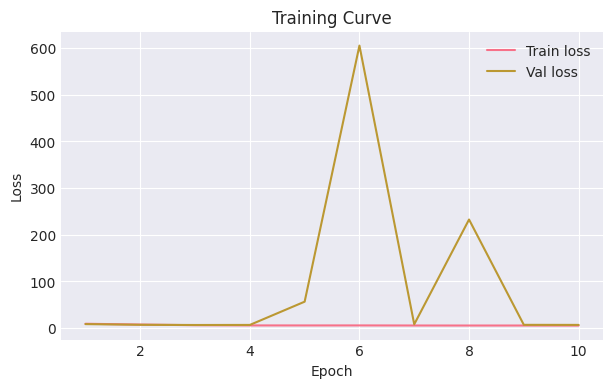

In [52]:
import json
import matplotlib.pyplot as plt
import os

history_path = os.path.join(RESULTS_DIR, "training_history.json")
print("Reading:", history_path)

with open(history_path, "r") as f:
    hist = json.load(f)

# Hist can be either dict-of-lists or list-of-epoch-dicts.
# Try to normalize.
if isinstance(hist, list):
    epochs = [e.get("epoch", i+1) for i, e in enumerate(hist)]
    train_loss = [e.get("train_loss") for e in hist]
    val_loss = [e.get("val_loss") for e in hist]
else:
    epochs = list(range(1, len(hist.get("train_loss", [])) + 1))
    train_loss = hist.get("train_loss", [])
    val_loss = hist.get("val_loss", [])

plt.figure(figsize=(7,4))
plt.plot(epochs, train_loss, label="Train loss")
plt.plot(epochs, val_loss, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.grid(True)
plt.legend()
plt.show()
